# APRENDIZAJE SUPERVISADO (DengAI)<center>

**Nombre y apellidos:** Jesús Iván Pacheco Romero


---
# Resumen
---

Este proyecto se enfoca en Experimentar diferentes modelos de Aprendizaje Supervisado para encontrar el mejor modelo que prediga la cantidad de casos de dengue, utilizando Features asociadas a la vegetaciòn y variables climáticas como temperatura, presión y humedad específicamente para dos ciudades Iquitos y San Juan en Perú.

En primera Fase se realiza un análisis para detectar outliers de forma general, por ciudad y por año ya que las variables presentan comportamientos diferentes para las dos ciudades con comportamientos similares por año. Se realiza exploración mediante Boxplot para detectar esos outliers, Gráficos de dispersión para detectar grupos en la exploración y histogramas para comprender las distribuciones de las Features.

La segunda Fase del Proyecto y la más importante consta de los Algoritmos de aprendizaje supervisado de regresión K vecinos más cercanos (KNN), Árbol de Decisión (DecisionTreeRegression), Random Forest( RandomForestRegressor) y  AdaBoostRegressor


---
# Inicialización
---

In [ ]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)


In [ ]:
#Clase Creada para Expolarar la Data en la actividad 1
import seaborn as sns
import matplotlib.pyplot as plt

class Visualizador_Features:
    def __init__(self, data):
        self.data = data

    def plot_box_strip(self, rows, cols, col_x, title, fig_size, color='blue', font_y=8,font_x=8):
        fig, axes = plt.subplots(rows, cols, figsize=fig_size)
        fig.tight_layout(pad=3.0, h_pad=3)

        for i in range(1, len(self.data.columns), 1):
            ax = sns.boxplot(data=self.data, y=self.data.iloc[:, i], x=col_x, ax=axes[(i-1)//cols, (i-1)%cols], color=".9", dodge=True, fliersize=False)
            ax.set_xlabel(col_x, fontsize=font_x)
            ax.set_ylabel(self.data.columns[i], fontsize=font_y)
            sns.stripplot(data=self.data, y=self.data.iloc[:, i], ax=axes[(i-1)//cols, (i-1)%cols], x=col_x, color=color)

        fig.suptitle(title, fontsize=16)
        plt.show()


    def plot_reg(self, rows, cols, title, fig_size, color='blue',font_y=8):
      fig, axes = plt.subplots(rows, cols, figsize=fig_size)
      fig.tight_layout(pad=3.0, h_pad=3)

      for i in range(1, len(self.data.columns), 1):
        ax = sns.regplot(data=self.data, x=self.data.iloc[:, i].index, y=self.data.iloc[:, i],scatter_kws={"color": color}, line_kws={"color": "black"},ax=axes[(i-1)//cols, (i-1)%cols])
        ax.set_xlabel('Índice')
        ax.set_ylabel(self.data.columns[i], fontsize=font_y)
      fig.suptitle(title, fontsize=16)
      plt.show()




    def plot_hist(self, rows, cols, title, fig_size, color='blue',font_x=8):
      fig, axes = plt.subplots(rows, cols, figsize=fig_size)
      fig.tight_layout(pad=3.0, h_pad=3)
      for i in range(1, len(self.data.columns), 1):
        ax=sns.histplot(data=self.data, x=self.data.iloc[:, i],ax=axes[(i-1)//cols, (i-1)%cols], color=color)
        ax.set_xlabel(self.data.columns[i], fontsize=font_x)

      fig.suptitle(title, fontsize=16)
      plt.show()


In [ ]:
#Función Creada para la practica 1, la función detecta outliers por year
def outlier_box_per_year(data,col, factor=1.5):
  #Función para encontrar los indices de los outliers de una Feature clasificada por año
  iqr_por_año = {}
  indices=[]
  indices_=[]
  for año in data['year'].unique():
    df_año = data[data['year'] == año]
    Q1=df_año[col].quantile(0.25)
    Q3= df_año[col].quantile(0.75)
    IQR=Q3-Q1

    lower_bound=Q1-factor*IQR
    upper_bound=Q3+factor*IQR
    indice=df_año[(df_año[col] >= upper_bound) | (df_año[col] <= lower_bound)].index.to_list()
    iqr_por_año[año]=indice
    indices.append(indice)
    indices_=[indice for sublista in indices for indice in sublista]


  return iqr_por_año, indices_

In [ ]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)-
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   
3  0.235886                 15.36             298.987143  ...   
4  0.247340                  7.52             299.518571  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   
3                            13.90                             80.337143   
4                            12.20                             80.460000   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   
3                         15.36                              16.672857   
4                          7.52                              17.210000   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   
3           2.428571           27.471429                 6.771429   
4           3.014286           28.942857                 9.371429   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                29.4                20.0               16.0  
1                31.7                22.2                8.6  
2                32.2                22.8               41.4  
3                33.3                23.3                4.0  
4                35.0                23.9                5.8  

[5 rows x 24 columns]

In [ ]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

Saving dengue_features_train.csv to dengue_features_train (1).csv
User uploaded file "dengue_features_train (1).csv" with length 287139 bytes
(1456, 45)


city  year  weekofyear week_start_date_x  ndvi_ne_x  ndvi_nw_x  ndvi_se_x  \
0   sj  1990          18        1990-04-30   0.122600   0.103725   0.198483   
1   sj  1990          19        1990-05-07   0.169900   0.142175   0.162357   
2   sj  1990          20        1990-05-14   0.032250   0.172967   0.157200   
3   sj  1990          21        1990-05-21   0.128633   0.245067   0.227557   
4   sj  1990          22        1990-05-28   0.196200   0.262200   0.251200   

   ndvi_sw_x  precipitation_amt_mm_x  reanalysis_air_temp_k_x  ...  \
0   0.177617                   12.42               297.572857  ...   
1   0.155486                   22.82               298.211429  ...   
2   0.170843                   34.54               298.781429  ...   
3   0.235886                   15.36               298.987143  ...   
4   0.247340                    7.52               299.518571  ...   

   reanalysis_precip_amt_kg_per_m2_y  reanalysis_relative_humidity_percent_y  \
0                              32.00                               73.365714   
1                              17.94                               77.368571   
2                              26.10                               82.052857   
3                              13.90                               80.337143   
4                              12.20                               80.460000   

   reanalysis_sat_precip_amt_mm_y  reanalysis_specific_humidity_g_per_kg_y  \
0                           12.42                                14.012857   
1                           22.82                                15.372857   
2                           34.54                                16.848571   
3                           15.36                                16.672857   
4                            7.52                                17.210000   

   reanalysis_tdtr_k_y  station_avg_temp_c_y  station_diur_temp_rng_c_y  \
0             2.628571             25.442857                   6.900000   
1             2.371429             26.714286                   6.371429   
2             2.300000             26.714286                   6.485714   
3             2.428571             27.471429                   6.771429   
4             3.014286             28.942857                   9.371429   

   station_max_temp_c_y  station_min_temp_c_y  station_precip_mm_y  
0                  29.4                  20.0                 16.0  
1                  31.7                  22.2                  8.6  
2                  32.2                  22.8                 41.4  
3                  33.3                  23.3                  4.0  
4                  35.0                  23.9                  5.8  

[5 rows x 45 columns]

In [ ]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes
(416, 24)


city  year  weekofyear week_start_date  ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  2008          18      2008-04-29  -0.0189 -0.018900  0.102729   
1   sj  2008          19      2008-05-06  -0.0180 -0.012400  0.082043   
2   sj  2008          20      2008-05-13  -0.0015       NaN  0.151083   
3   sj  2008          21      2008-05-20      NaN -0.019867  0.124329   
4   sj  2008          22      2008-05-27   0.0568  0.039833  0.062267   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.091200                 78.60             298.492857  ...   
1  0.072314                 12.56             298.475714  ...   
2  0.091529                  3.66             299.455714  ...   
3  0.125686                  0.00             299.690000  ...   
4  0.075914                  0.76             299.780000  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            25.37                             78.781429   
1                            21.83                             78.230000   
2                             4.12                             78.270000   
3                             2.20                             73.015714   
4                             4.36                             74.084286   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         78.60                              15.918571   
1                         12.56                              15.791429   
2                          3.66                              16.674286   
3                          0.00                              15.775714   
4                          0.76                              16.137143   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           3.128571           26.528571                 7.057143   
1           2.571429           26.071429                 5.557143   
2           4.428571           27.928571                 7.785714   
3           4.342857           28.057143                 6.271429   
4           3.542857           27.614286                 7.085714   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                33.3                21.7               75.2  
1                30.0                22.2               34.3  
2                32.8                22.8                3.0  
3                33.3                24.4                0.3  
4                33.3                23.3               84.1  

[5 rows x 24 columns]

---
# Reexploración
---

Para Llenar los Datos Faltantes utilizaremos la tècnica aprendida en la actividad 1 en la que luego de explorar el comportamiento de las Features, se realiza el llenado de los datos teniendo en cuenta su comportamiento Lineal, estacionario o constante por cada ciudad. A continuaciòn se traen algunos fragmentos de código y texto Markdown de la actividad 1.

Se decide realizar el análisis por año en los outliers ya que es claro que para las Features ndvi_ne, ndvi_nw en la ciudad de San juan tienen una fuerte relación lineal con el tiempo de los indices de vegetación para estos dos sectores, mediante el grafico de Dispersión se observa una pendiente negativa con el aumento de los años, lo que nos indica que estás Features pueden mejorarse eliminado los outliers por año, para asi lograr mejores resultados a la hora de llenar datos Faltantes con interpolación lineal. En esta sección se crea una función que identifica los indices outliers por año en las fetures seleccionadas, luego se revisa con el grafico de Boxplot por año si es necesario volver a correr la función para eliminar outliers. Al final de eliminar outliers completamos datos faltantes meidnate el método seleccioando según la feature interpolación lineal o ffill.


In [ ]:
# EJEMPLO: Eliminar variable week_start_date por ser de tipo cadena de texto sin formato
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)

In [ ]:
# EJEMPLO: Contar valores perdidos
pd.isnull(train).sum()

city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_pr

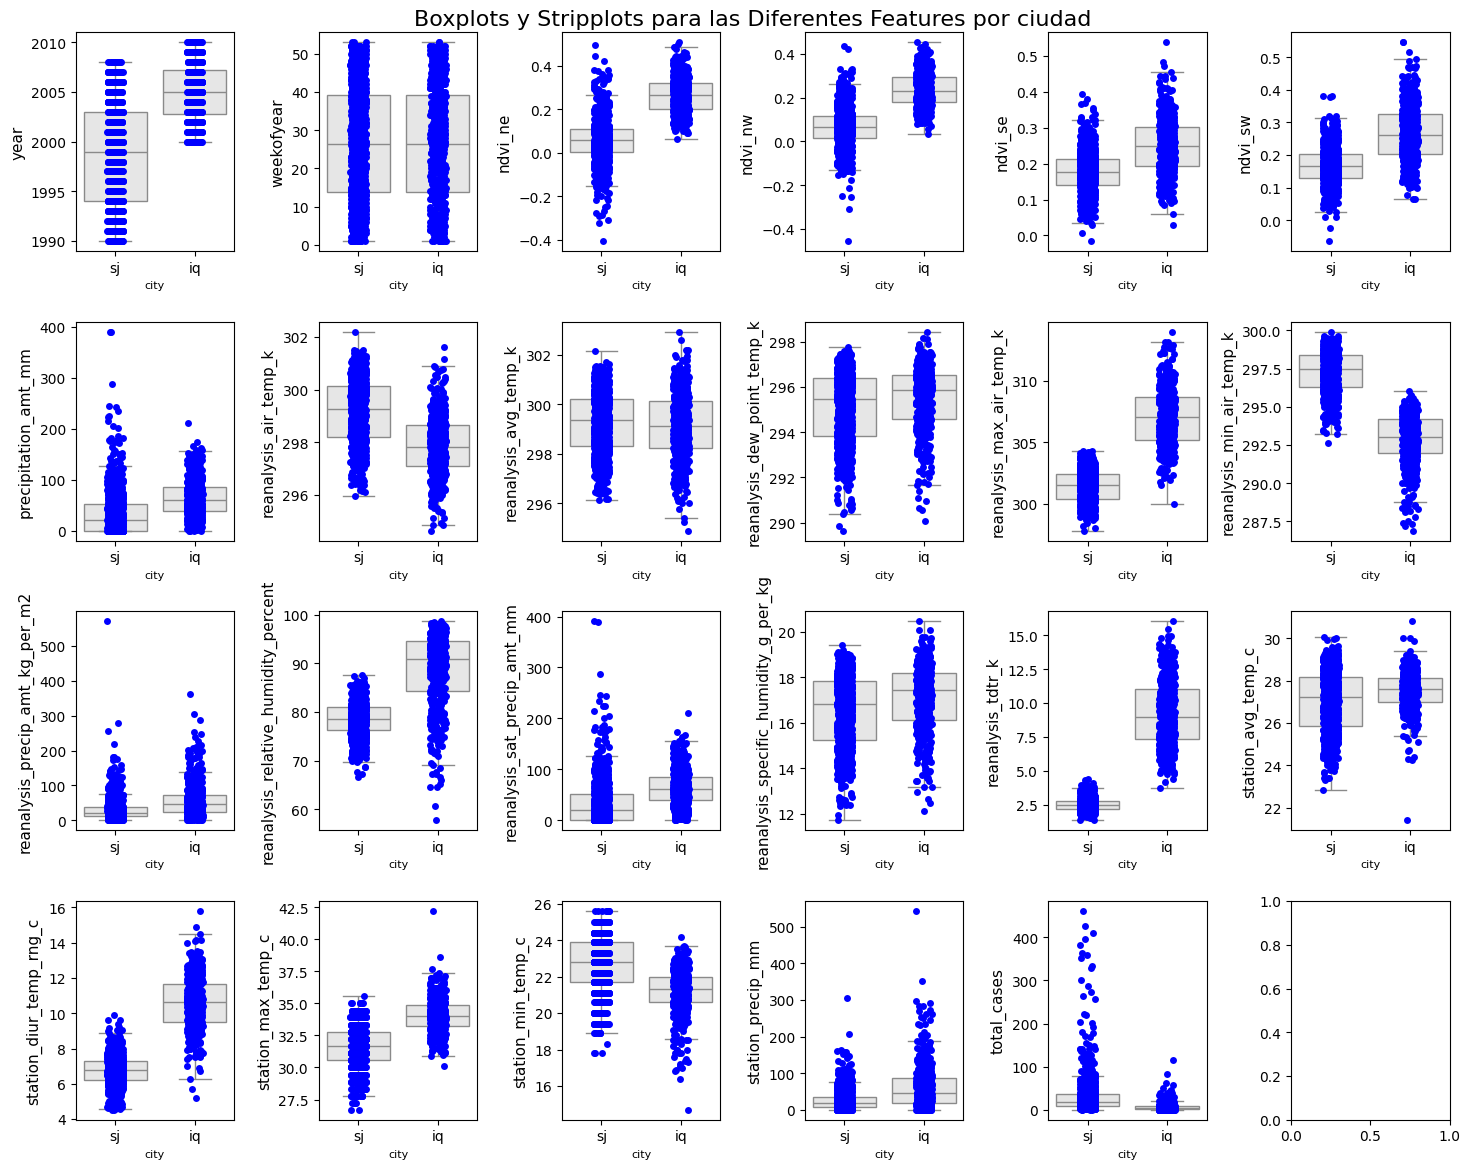

In [ ]:
#Se generan Boxplots dividios por ciudad
visualizer = Visualizador_Features(train)

# Luego, llamamos al método plot_box_strip
visualizer.plot_box_strip(rows=4, cols=6, col_x='city', title='Boxplots y Stripplots para las Diferentes Features por ciudad', fig_size=(15,12), font_y=11)

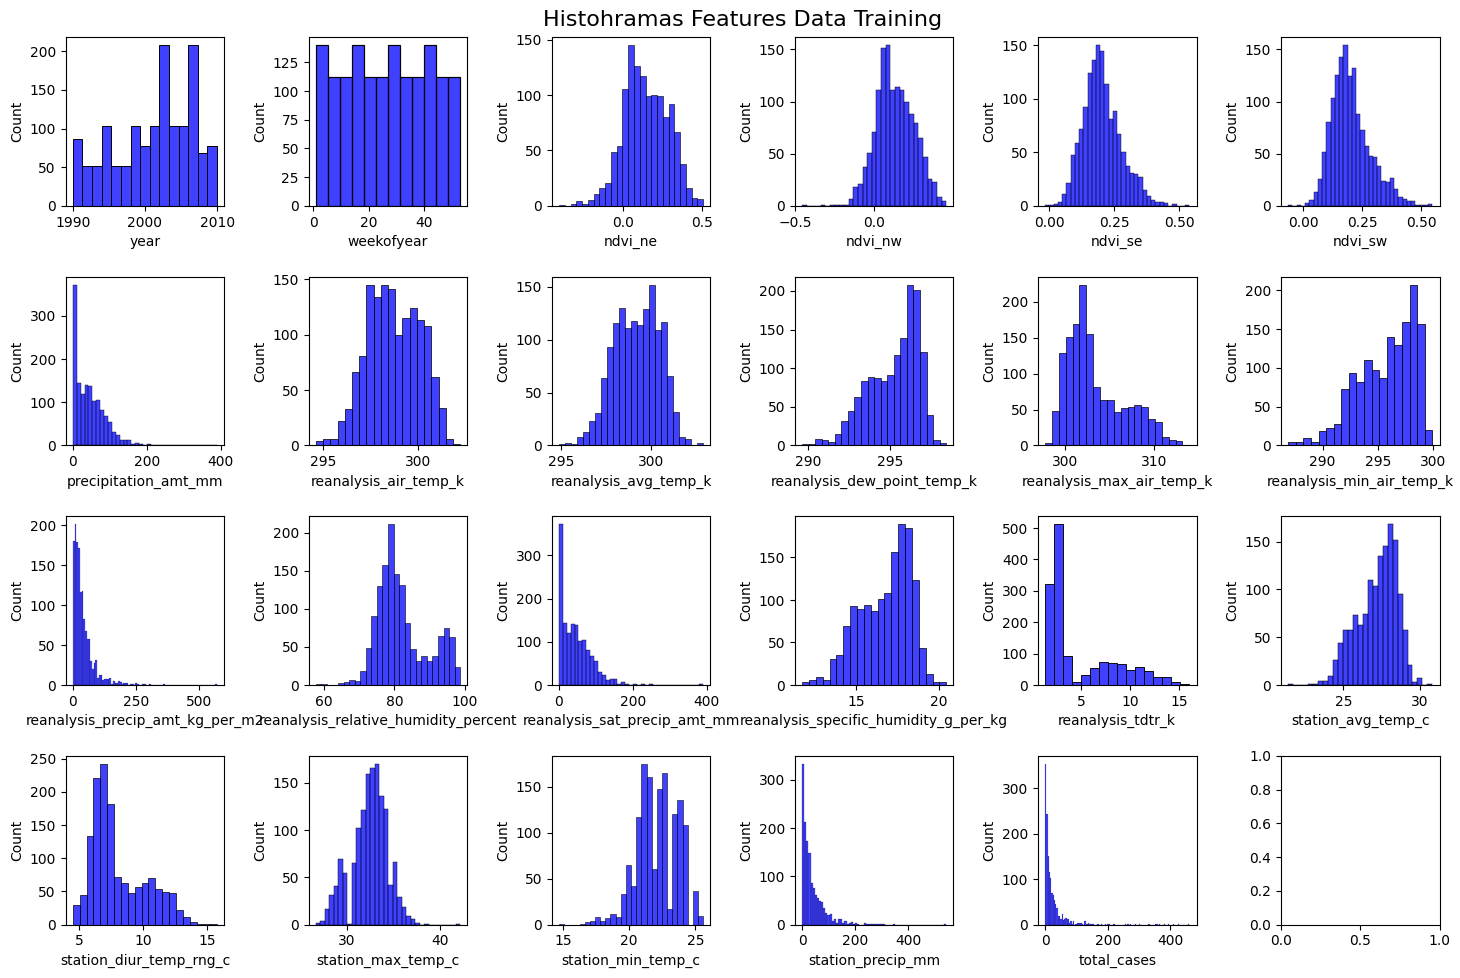

In [ ]:
visualizer.plot_hist(rows=4, cols=6, title='Histohramas Features Data Training', fig_size=(15, 10), font_x=10)

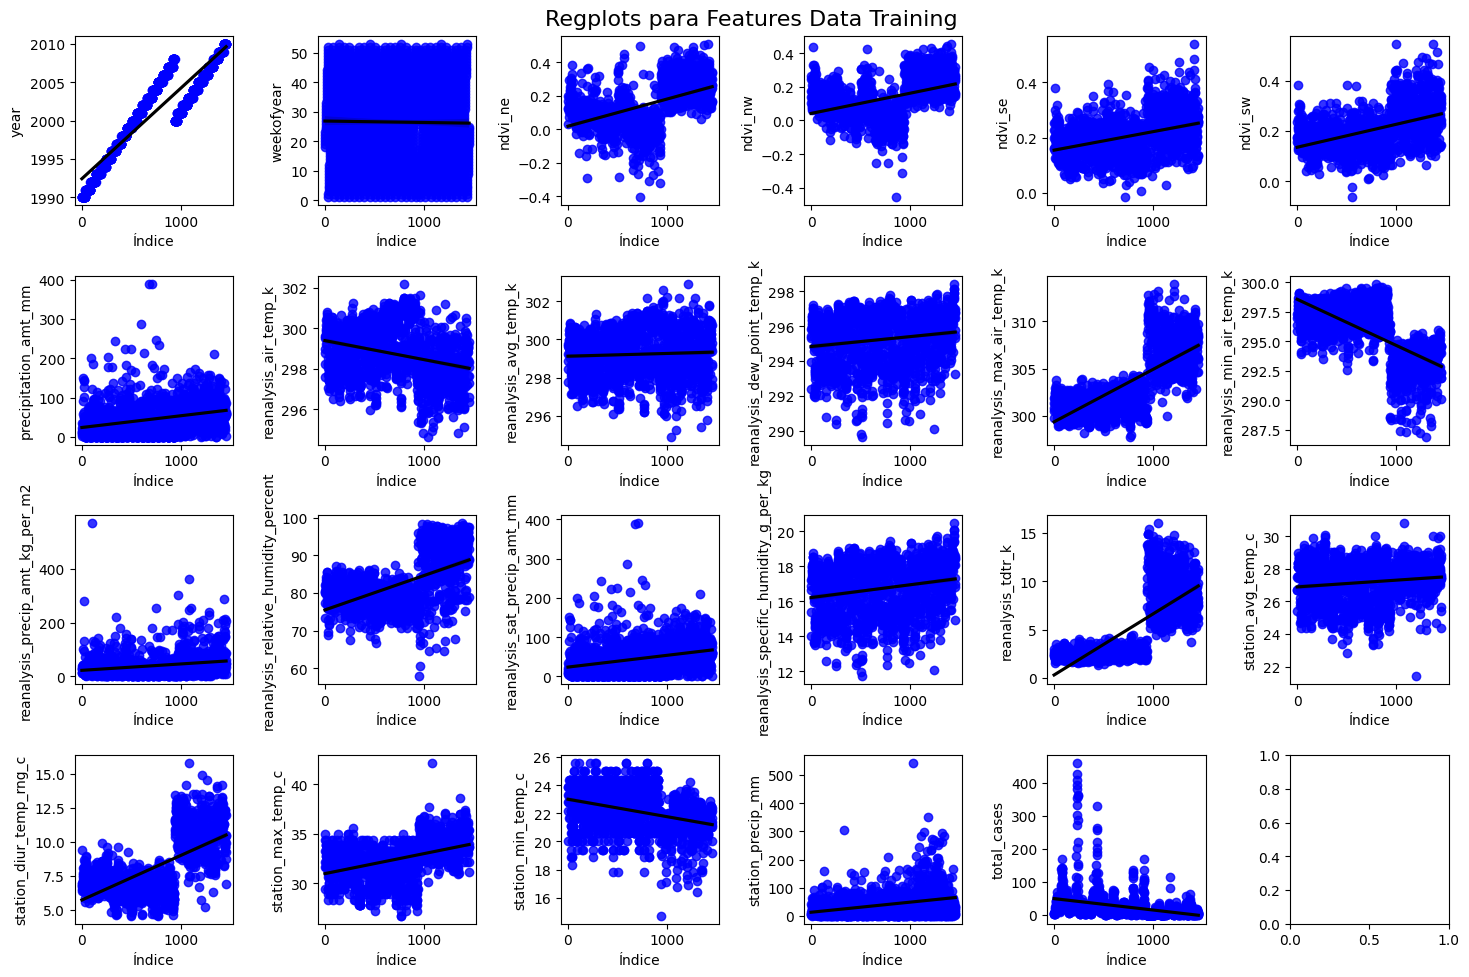

In [ ]:
visualizer.plot_reg(rows=4, cols=6, title='Regplots para Features Data Training', fig_size=(15, 10), color='blue', font_y=10)

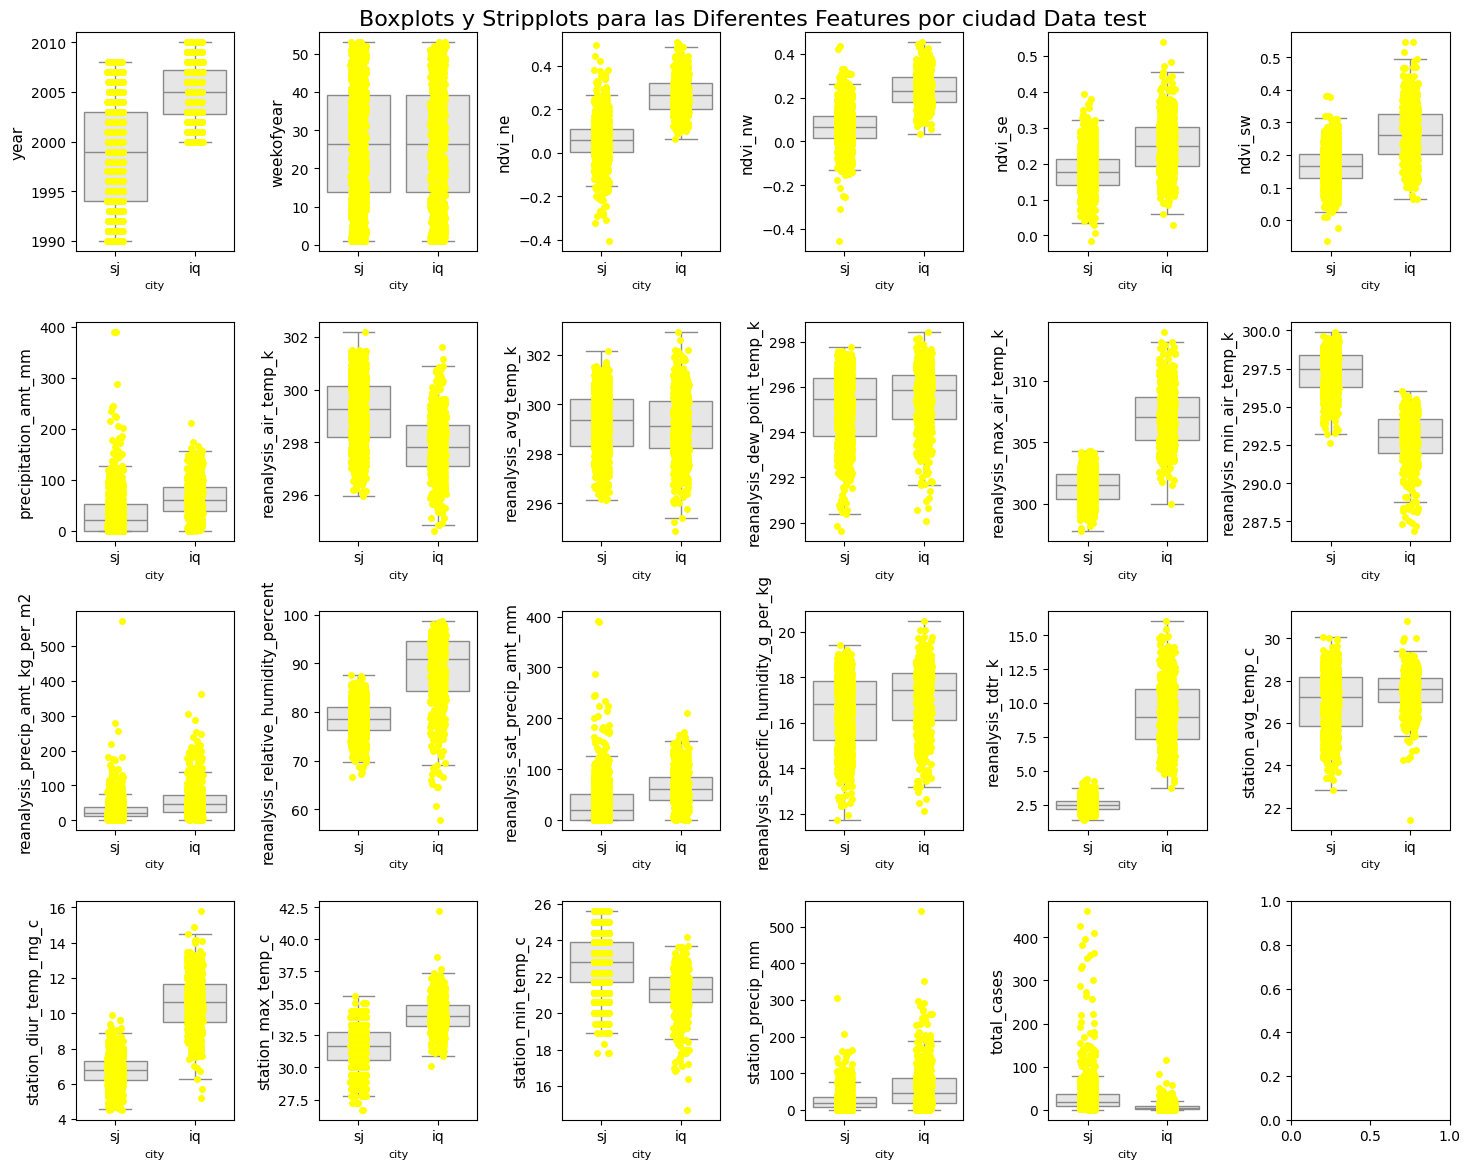

In [ ]:
#Se generan Boxplots dividios por ciudad
visualizer = Visualizador_Features(train)

# Luego, llamamos al método plot_box_strip
visualizer.plot_box_strip(rows=4, cols=6, col_x='city', title='Boxplots y Stripplots para las Diferentes Features por ciudad Data test', fig_size=(15,12), font_y=11, color='yellow')

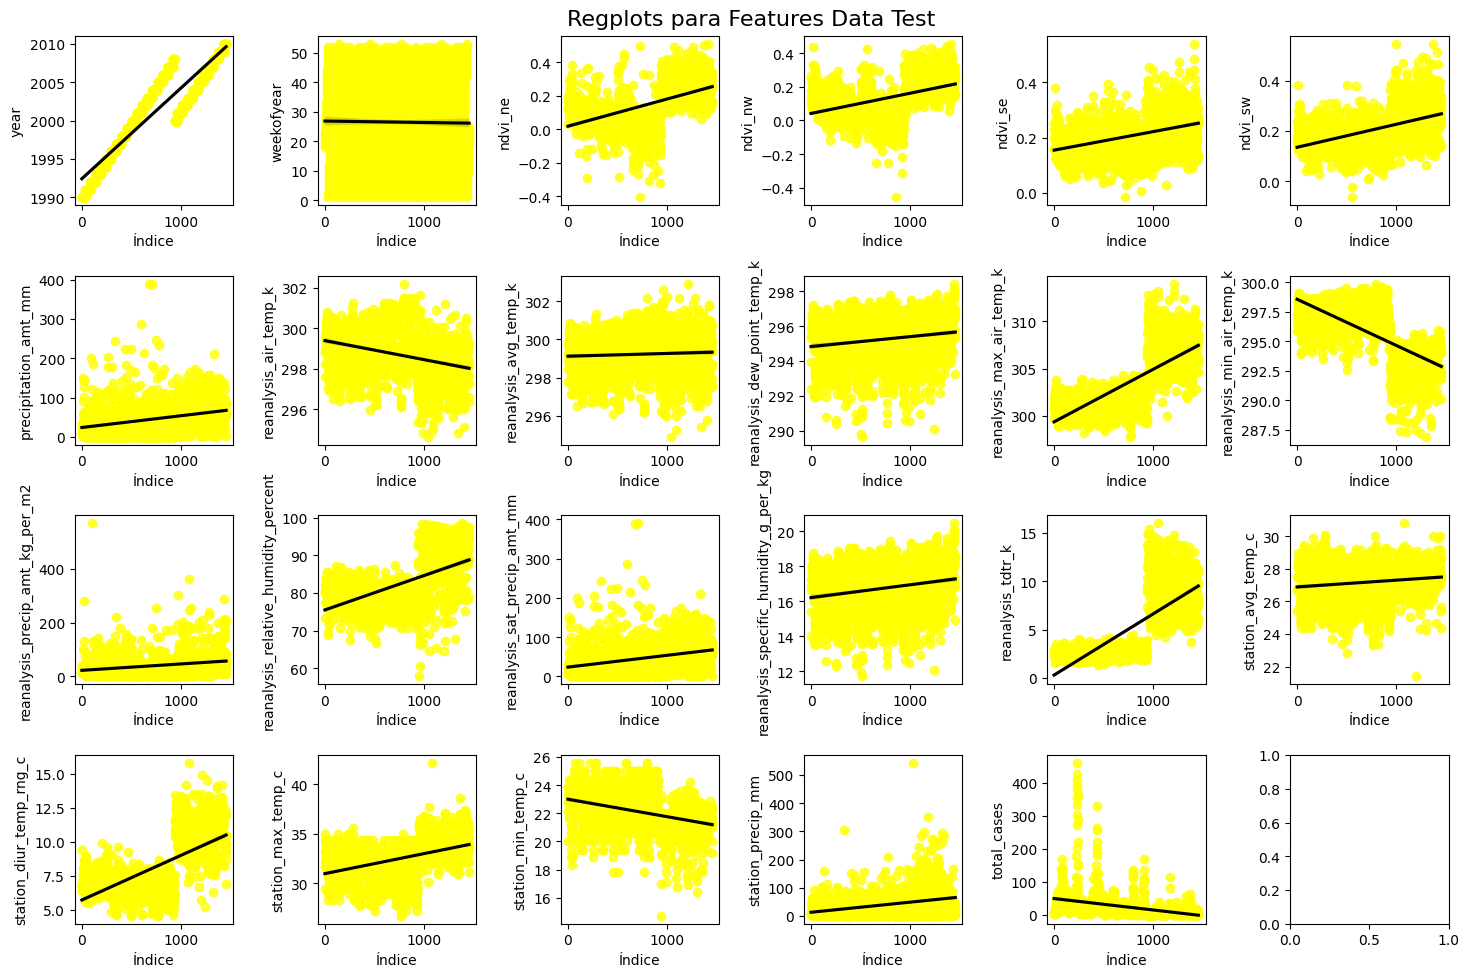

In [ ]:
visualizer.plot_reg(rows=4, cols=6, title='Regplots para Features Data Test', fig_size=(15, 10), color='yellow', font_y=10)

Se evidencia el mismo comportamiento de la data trainingo con la data Test en donde es muy claro los dos grupos para algunas Features.

## Análisis y tratamiento de outliers por año de las Features ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw para la ciudad de San juan

Se decide realizar el análisis por año en los outliers ya que es claro que para las Features ndvi_ne, ndvi_nw en la ciudad de San juan tienen una fuerte relación lineal con el tiempo de los indices de vegetación para estos dos sectores, mediante el grafico de Dispersión se observa una pendiente negativa con el aumento de los años, lo que nos indica que estás Features pueden mejorarse eliminado los outliers por año, para asi lograr mejores resultados a la hora de llenar datos Faltantes con interpolación lineal. En esta sección se crea una función que identifica los indices outliers por año en las fetures seleccionadas, luego se revisa con el grafico de Boxplot por año si es necesario volver a correr la función para eliminar outliers. Al final de eliminar outliers completamos datos faltantes meidnate el método seleccioando según la feature interpolación lineal o ffill.

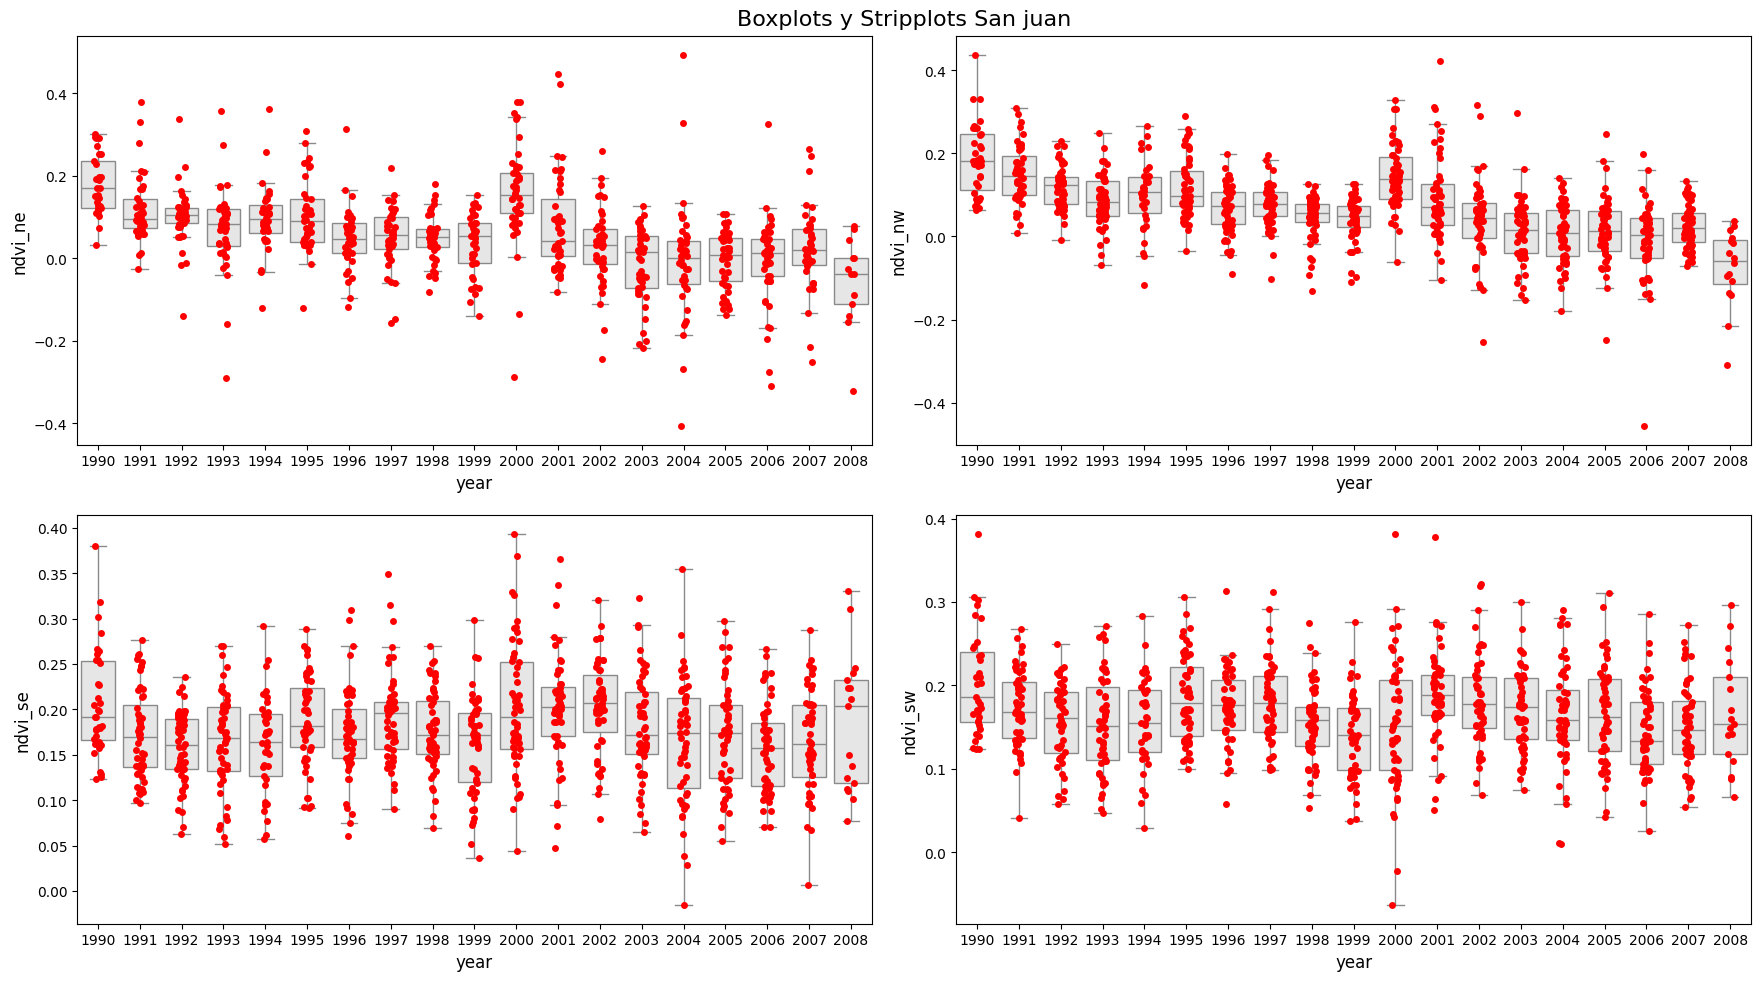

In [ ]:
box_sj=train[train['city']=='sj']

box_sj=box_sj.iloc[:,[1,3,4,5,6]]
visualizer = Visualizador_Features(box_sj)

visualizer.plot_box_strip(rows=2, cols=2, col_x='year', title='Boxplots y Stripplots San juan', fig_size=(18, 10), color='red', font_y=12, font_x=12)

Tratamiento de Outliers
Para realizar el llenado de los datos se utiliza el mètodo fillna llenando con el anterior dato al faltante y el mètodo interpolate que interpola entre dos nùmero uno por encima y uno por debajo del faltante utilizando un mètodo lineal en este caso. para la utilizaciòn de estos dos mètodos se realizò una experimentaciòn en la practica 1 para escoger a qeu features aplicar cada cual.

In [ ]:
train.loc[train['city'] == 'sj', 'ndvi_ne'] = train[train['city'] == 'sj']['ndvi_ne'].interpolate(method='linear')
train.loc[train['city'] == 'sj', 'ndvi_nw'] = train[train['city'] == 'sj']['ndvi_nw'].interpolate(method='linear')
train.loc[train['city'] == 'sj', 'ndvi_se'] = train[train['city'] == 'sj']['ndvi_se'].fillna(method='ffill')
train.loc[train['city'] == 'sj', 'ndvi_sw'] = train[train['city'] == 'sj']['ndvi_sw'].fillna(method='ffill')


In [ ]:
dict_nvdi_ne, list_nvdi_ne=outlier_box_per_year(box_sj, 'ndvi_ne')
indice_nvdi_nw, list_nvdi_nw=outlier_box_per_year(box_sj, 'ndvi_nw')
indice_nvdi_se,list_nvdi_se=outlier_box_per_year(box_sj, 'ndvi_se')
indice_nvdi_sw,list_nvdi_sw=outlier_box_per_year(box_sj, 'ndvi_sw')

lista_unida = list(set(list_nvdi_ne + list_nvdi_nw+ list_nvdi_se+list_nvdi_sw))
print('data antes de eliminar outliers:',len(train))
train=train.drop(lista_unida)
print('data después de eliminar outliers:' ,len(train))

data antes de eliminar outliers: 1456
data después de eliminar outliers: 1363


## Análisis y tratamiento de outliers por año de las Features Restantes de San Juan

Luego de tratar las 4 Features Anteriores para la ciudad de San juan se realiza el tratamiento para las Features Faltantes y al revisar el comportamiento en los graficos de Dispersión encontramos tendecias estacionarias para algunas Features por lo que para estas Features y las que muestran comportamiento lineal se decide realizar el llenado de datos Faltantes con interpolate('linear'), para las qeu no muestran estos comportamientos utilizamos el método fillna().

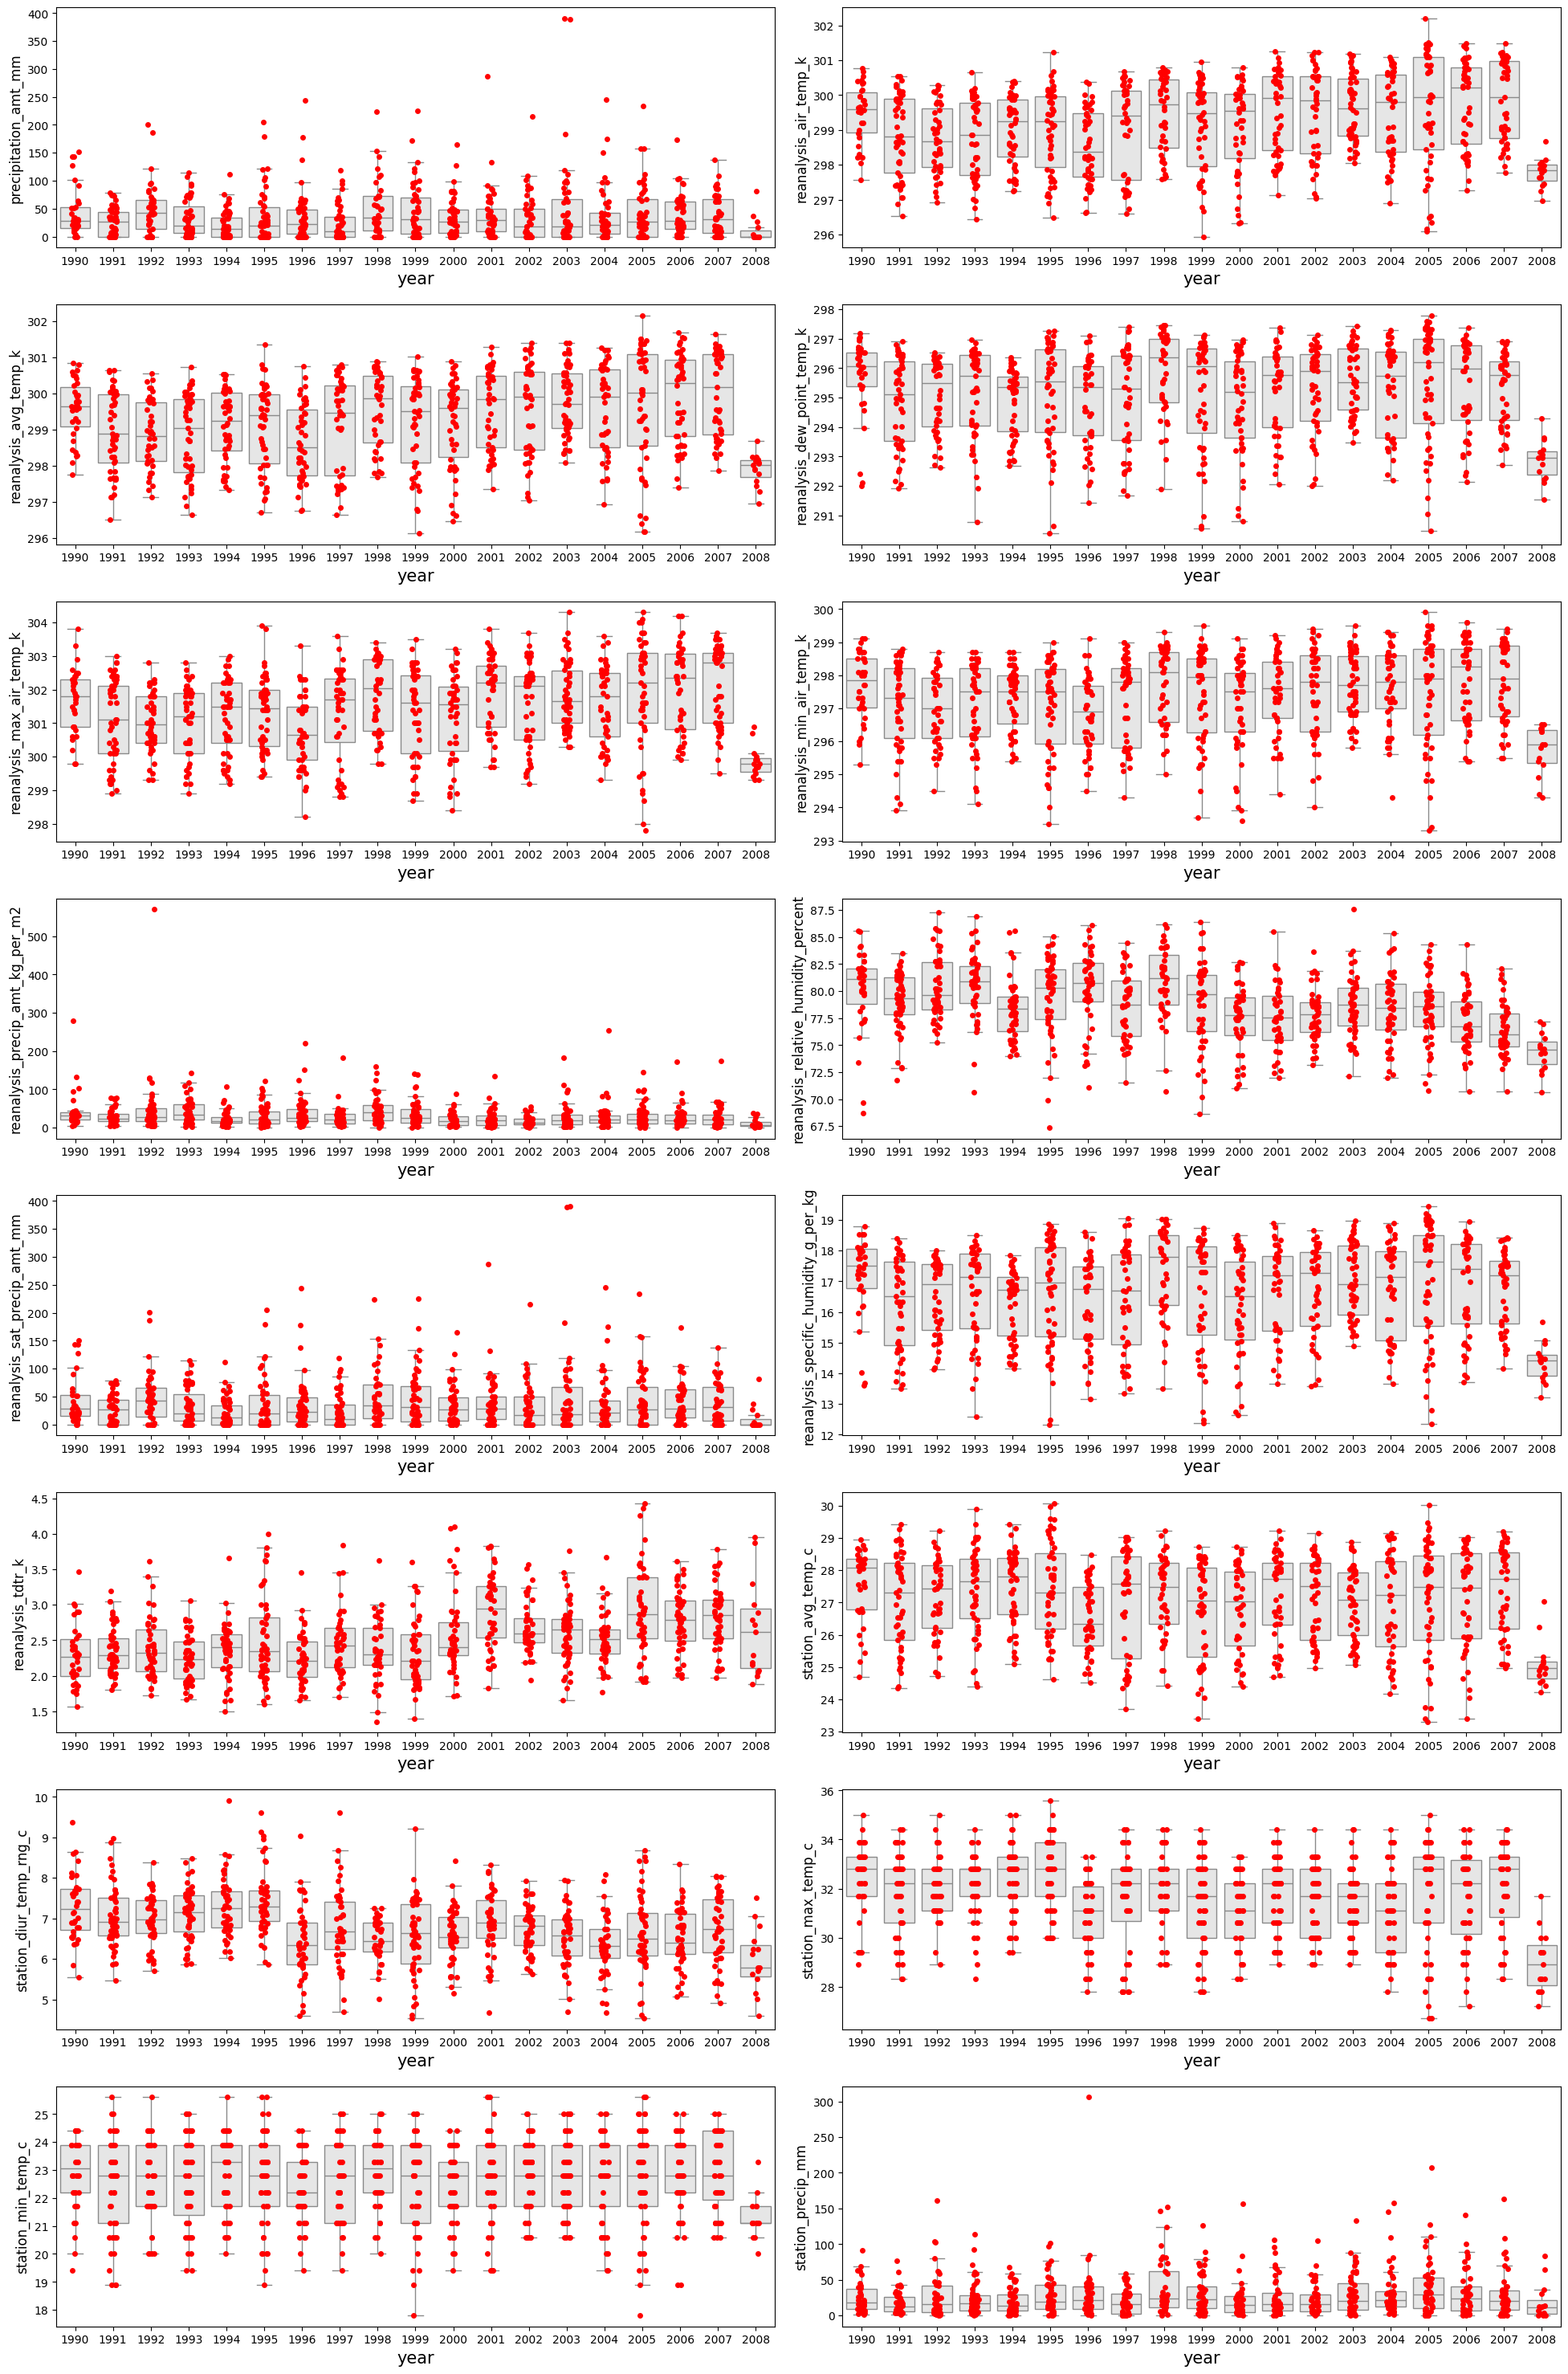

In [ ]:
lista_sj_16_fea=box_sj.iloc[:,1:].columns.tolist()

box_sj=train[train['city']=='sj']

box_sj=box_sj.iloc[:,[1,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]
box_sj

visualizer = Visualizador_Features(box_sj)

visualizer.plot_box_strip(rows=8, cols=2, col_x='year', title='', fig_size=(20,30), color='red', font_y=12, font_x=15)

In [ ]:
lista_sj_16_fea=box_sj.iloc[:,1:].columns.tolist()

In [ ]:
#Identificamos los outliers guardamos sus indices en la list_total asi como para cada feature los inidices por año en el dict_total si queremos consultar
list_total=[]
dict_total={}
for col in lista_sj_16_fea:
   dict_, list_=outlier_box_per_year(box_sj,col, factor=1.5)

   dict_total[col]=dict_
   list_total.append(list_)

lista_aplanada = set([item for sublist in list_total for item in sublist])
print(len(lista_aplanada))
print(len(train[train['city']=='sj'])-len(lista_aplanada))

155
688


In [ ]:
#Se seleccionan las Features Lineales y estacionarias en una lista y las que no en otra lista
lista_estacionaria_sj=[]
lista_no_estacionaria_sj=[]

lista_estacionaria_sj=train[train['city']=='sj'].iloc[:,[8,9,10,11,12,14,16,17,18,19,20,21]].columns.tolist()
lista_no_estacionaria_sj=train[train['city']=='sj'].iloc[:,[7,13,15,22]].columns.tolist()

In [ ]:
for col in lista_estacionaria_sj:
  train.loc[train['city'] == 'sj', col] = train[train['city'] == 'sj'][col].interpolate(method='linear')

for col in lista_no_estacionaria_sj:
  train.loc[train['city'] == 'sj', col] = train[train['city'] == 'sj'][col].fillna(method='ffill')

In [ ]:
train[train['city']=='sj'].isnull().sum()
print(train.shape)

(1363, 24)


In [ ]:

train.loc[train['city'] == 'iq', 'ndvi_ne'] = train[train['city'] == 'iq']['ndvi_ne'].interpolate(method='linear')
train.loc[train['city'] == 'iq', 'ndvi_nw'] = train[train['city'] == 'iq']['ndvi_nw'].interpolate(method='linear')
train.loc[train['city'] == 'iq', 'ndvi_se'] = train[train['city'] == 'iq']['ndvi_se'].fillna(method='ffill')
train.loc[train['city'] == 'iq', 'ndvi_sw'] = train[train['city'] == 'iq']['ndvi_sw'].fillna(method='ffill')

In [ ]:
pd.isnull(train).sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   0
ndvi_nw                                   0
ndvi_se                                   0
ndvi_sw                                   0
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c                        8
station_precip_mm               

## Análisis y tratamiento de outliers por año de las Features ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw para la ciudad de Iquitos

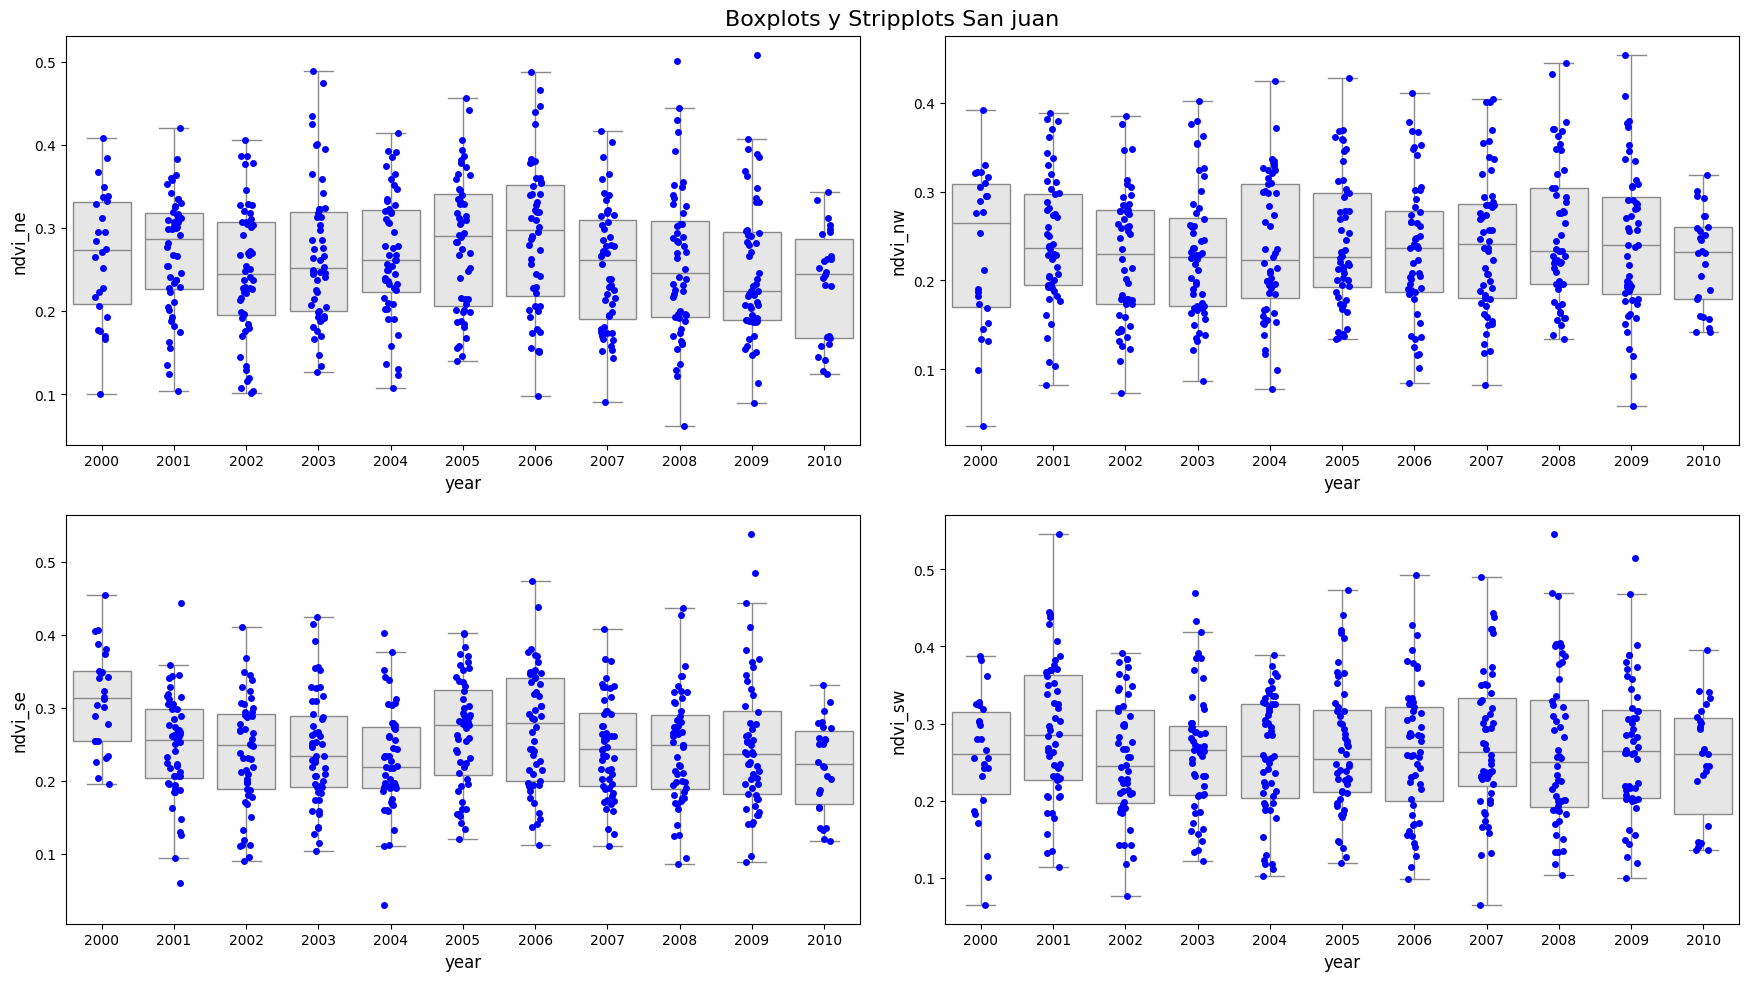

In [ ]:
box_iq=train[train['city']=='iq']

box_iq=box_iq.iloc[:,[1,3,4,5,6]]
visualizer = Visualizador_Features(box_iq)

visualizer.plot_box_strip(rows=2, cols=2, col_x='year', title='Boxplots y Stripplots San juan', fig_size=(18, 10), color='blue', font_y=12, font_x=12)

In [ ]:
dict_nvdi_ne, list_nvdi_ne=outlier_box_per_year(box_iq, 'ndvi_ne')
indice_nvdi_nw, list_nvdi_nw=outlier_box_per_year(box_iq, 'ndvi_nw')
indice_nvdi_se,list_nvdi_se=outlier_box_per_year(box_iq, 'ndvi_se')
indice_nvdi_sw,list_nvdi_sw=outlier_box_per_year(box_iq, 'ndvi_sw')

lista_unida = list(set(list_nvdi_ne + list_nvdi_nw+ list_nvdi_se+list_nvdi_sw))
print('data antes de eliminar outliers:',len(train))
train=train.drop(lista_unida)
print('data después de eliminar outliers:' ,len(train))

data antes de eliminar outliers: 1363
data después de eliminar outliers: 1354


In [ ]:
train=train.reset_index(drop=True)

In [ ]:
train.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   0
ndvi_nw                                   0
ndvi_se                                   0
ndvi_sw                                   0
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c                        8
station_precip_mm               

In [ ]:
train.loc[train['city'] == 'iq', 'ndvi_ne'] = train[train['city'] == 'iq']['ndvi_ne'].interpolate(method='linear')
train.loc[train['city'] == 'iq', 'ndvi_nw'] = train[train['city'] == 'iq']['ndvi_nw'].interpolate(method='linear')
train.loc[train['city'] == 'iq', 'ndvi_se'] = train[train['city'] == 'iq']['ndvi_se'].fillna(method='ffill')
train.loc[train['city'] == 'iq', 'ndvi_sw'] = train[train['city'] == 'iq']['ndvi_sw'].fillna(method='ffill')

In [ ]:
train.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   0
ndvi_nw                                   0
ndvi_se                                   0
ndvi_sw                                   0
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c                        8
station_precip_mm               

In [ ]:
test.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm               

## Análisis y tratamiento de outliers por año de las Features Restantes de Iquitos

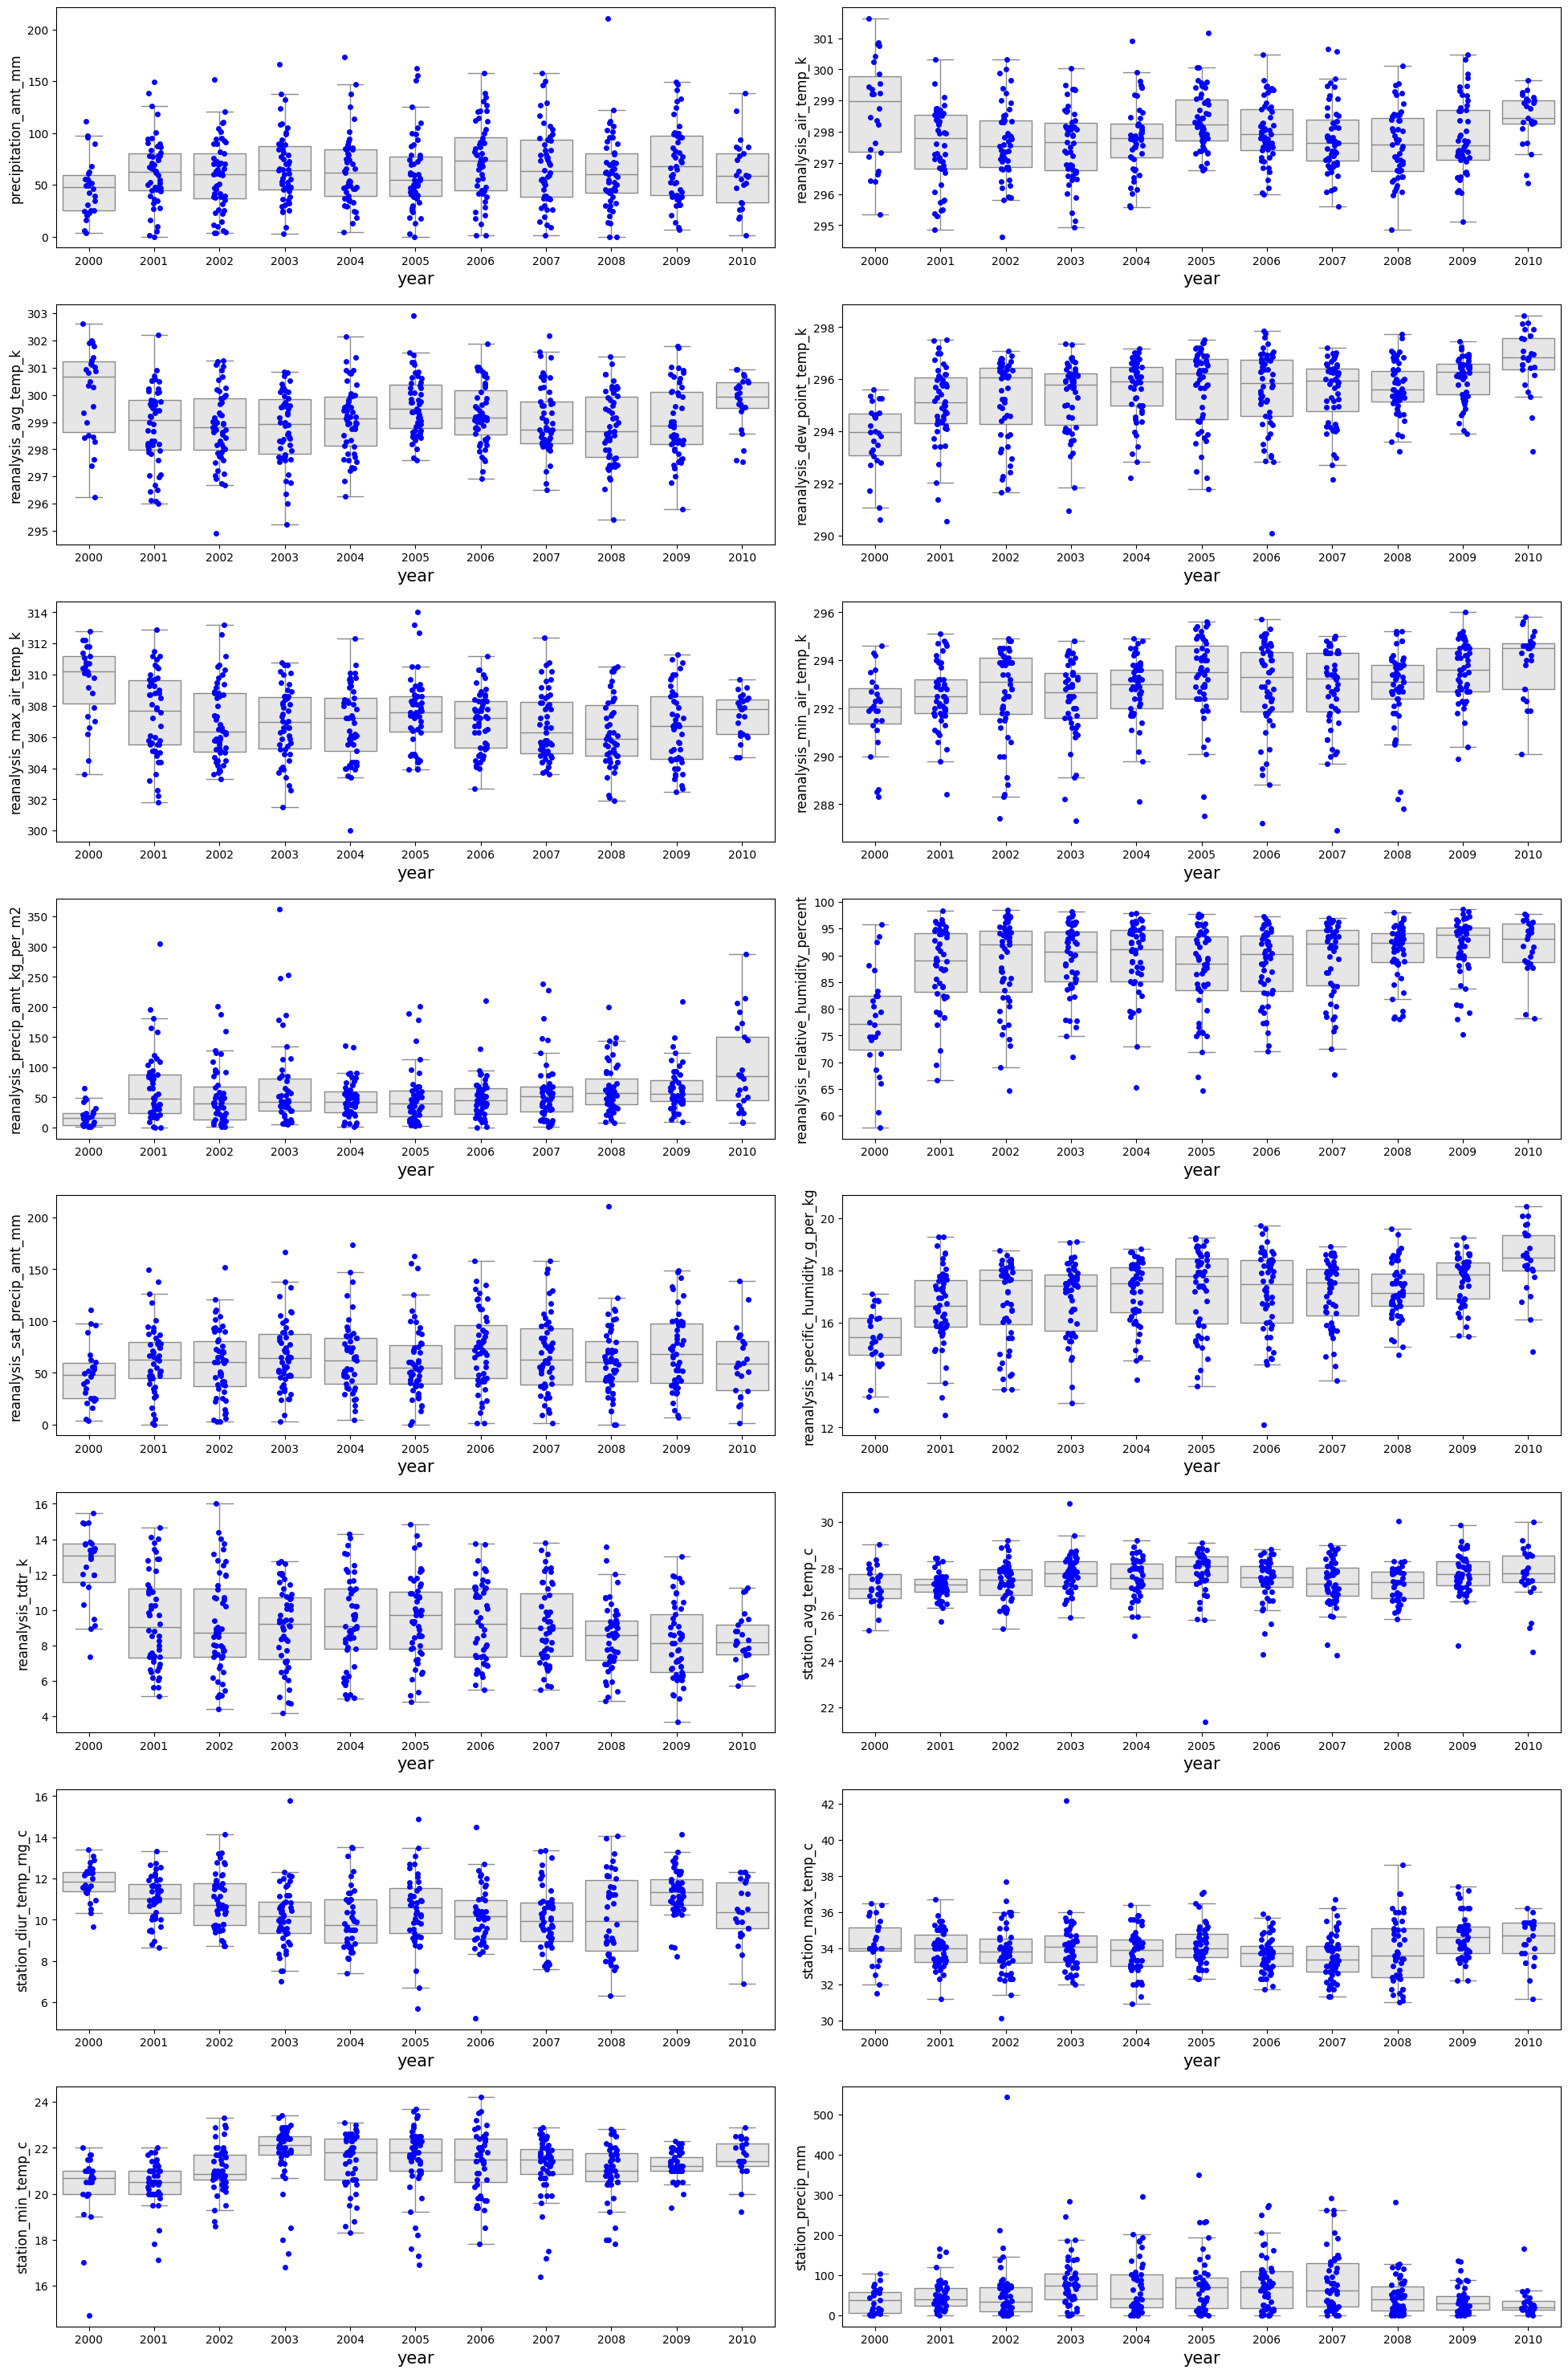

In [ ]:
# box_sj=train[train['city']=='sj']
box_iq=train[train['city']=='iq']

box_iq=box_iq.iloc[:,[1,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]
box_iq

visualizer = Visualizador_Features(box_iq)

visualizer.plot_box_strip(rows=8, cols=2, col_x='year', title='', fig_size=(20,30), color='blue', font_y=12, font_x=15)

In [ ]:
lista_iq_16_fea=box_iq.iloc[:,1:].columns.tolist()

In [ ]:
#Identificamos los outliers guardamos sus indices en la list_total asi como para cada feature los inidices por año en el dict_total si queremos consultar
list_total=[]
dict_total={}
for col in lista_iq_16_fea:
   dict_, list_=outlier_box_per_year(box_iq,col, factor=1.5)

   dict_total[col]=dict_
   list_total.append(list_)

lista_aplanada = set([item for sublist in list_total for item in sublist])
print(len(lista_aplanada))
print(len(train[train['city']=='iq'])-len(lista_aplanada))

125
386


In [ ]:
#Se seleccionan las Features Lineales y estacionarias en una lista y las que no en otra lista
lista_estacionaria_iq=[]
lista_no_estacionaria_iq=[]

lista_estacionaria_iq=train[train['city']=='iq'].iloc[:,[8,9,10,11,12,14,16,17,18,19,20,21]].columns.tolist()
lista_no_estacionaria_iq=train[train['city']=='iq'].iloc[:,[7,13,15,22]].columns.tolist()

In [ ]:
for col in lista_estacionaria_iq:
  train.loc[train['city'] == 'iq', col] = train[train['city'] == 'iq'][col].interpolate(method='linear')

for col in lista_no_estacionaria_iq:
  train.loc[train['city'] == 'iq', col] = train[train['city'] == 'iq'][col].fillna(method='ffill')

In [ ]:
print(train.shape)
train[train['city']=='iq'].isnull().sum()

(1354, 24)


city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases

Para el llenado y tratamiento de datos en el Dataset de Test se utilizarà un mètodo màs simple que el utilizado para los de training ya que la porciòn para el test es màs reducida, pero utilizando lo mismos mètodos de llenando de faltantes para las Features ya tratadas teniendo en cuenta el comportamiento de las Features si tiene un comportamiento màs lineal con respecto al tiempo, estacionaria o no se evidencia relaciòn.

In [ ]:
test.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm               

In [ ]:
test.loc[:, 'ndvi_ne'] = test[:]['ndvi_ne'].interpolate(method='linear')
test.loc[:, 'ndvi_nw'] = test[:]['ndvi_nw'].interpolate(method='linear')
test.loc[:, 'ndvi_se'] = test[:]['ndvi_se'].fillna(method='ffill')
test.loc[:, 'ndvi_sw'] = test[:]['ndvi_sw'].fillna(method='ffill')

In [ ]:
test.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   0
ndvi_nw                                   0
ndvi_se                                   0
ndvi_sw                                   0
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm               

In [ ]:
lista_estacionaria=[]
lista_no_estacionaria=[]

lista_estacionaria=test.iloc[:,[8,9,10,11,12,14,16,17,18,19,20,21]].columns.tolist()
lista_no_estacionaria_iq=test.iloc[:,[7,13,15,22]].columns.tolist()


In [ ]:
for col in lista_estacionaria_iq:
  test.loc[:, col] = test[:][col].interpolate(method='linear')

for col in lista_no_estacionaria_iq:
  test.loc[:, col] = test[:][col].fillna(method='ffill')

In [ ]:
test.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

In [ ]:
# EJEMPLO: Binarizador para la variable categórica city en el conjunto de entrenamiento y test
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

train.tail()

city  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
1349   iq  2010          21  0.342750  0.318900  0.256343  0.292514   
1350   iq  2010          22  0.160157  0.160371  0.136043  0.225657   
1351   iq  2010          23  0.247057  0.146057  0.250357  0.233714   
1352   iq  2010          24  0.333914  0.245771  0.278886  0.325486   
1353   iq  2010          25  0.298186  0.232971  0.274214  0.315757   

      precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  ...  \
1349                 55.30             299.334286             300.771429  ...   
1350                 86.47             298.330000             299.392857  ...   
1351                 58.94             296.598571             297.592857  ...   
1352                 59.67             296.345714             297.521429  ...   
1353                 63.22             298.097143             299.835714  ...   

      reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
1349                         55.30                              18.485714   
1350                         86.47                              18.070000   
1351                         58.94                              17.008571   
1352                         59.67                              16.815714   
1353                         63.22                              17.355714   

      reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
1349           9.800000           28.633333                11.933333   
1350           7.471429           27.433333                10.500000   
1351           7.500000           24.400000                 6.900000   
1352           7.871429           25.433333                 8.733333   
1353          11.014286           27.475000                 9.900000   

      station_max_temp_c  station_min_temp_c  station_precip_mm  total_cases  \
1349                35.4                22.4               27.0            5   
1350                34.7                21.7               36.6            8   
1351                32.2                19.2                7.4            1   
1352                31.2                21.0               16.0            1   
1353                33.7                22.2               20.4            4   

      city_bin  
1349         0  
1350         0  
1351         0  
1352         0  
1353         0  

[5 rows x 25 columns]

## Features

In [ ]:
y_train=train['total_cases']
data_total_train=train #Data total train
data_total_test=train #Data total train
train=train.drop('total_cases',axis=1)
train['total_cases']=y_train
train.iloc[:,3:]


ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
0     0.122600  0.103725  0.198483  0.177617                 12.42   
1     0.169900  0.142175  0.162357  0.155486                 22.82   
2     0.032250  0.172967  0.157200  0.170843                 34.54   
3     0.128633  0.245067  0.227557  0.235886                 15.36   
4     0.196200  0.262200  0.251200  0.247340                  7.52   
...        ...       ...       ...       ...                   ...   
1349  0.342750  0.318900  0.256343  0.292514                 55.30   
1350  0.160157  0.160371  0.136043  0.225657                 86.47   
1351  0.247057  0.146057  0.250357  0.233714                 58.94   
1352  0.333914  0.245771  0.278886  0.325486                 59.67   
1353  0.298186  0.232971  0.274214  0.315757                 63.22   

      reanalysis_air_temp_k  reanalysis_avg_temp_k  \
0                297.572857             297.742857   
1                298.211429             298.442857   
2                298.781429             298.878571   
3                298.987143             299.228571   
4                299.518571             299.664286   
...                     ...                    ...   
1349             299.334286             300.771429   
1350             298.330000             299.392857   
1351             296.598571             297.592857   
1352             296.345714             297.521429   
1353             298.097143             299.835714   

      reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
0                      292.414286                      299.8   
1                      293.951429                      300.9   
2                      295.434286                      300.5   
3                      295.310000                      301.4   
4                      295.821429                      301.9   
...                           ...                        ...   
1349                   296.825714                      309.7   
1350                   296.452857                      308.5   
1351                   295.501429                      305.5   
1352                   295.324286                      306.1   
1353                   295.807143                      307.8   

      reanalysis_min_air_temp_k  ...  reanalysis_sat_precip_amt_mm  \
0                         295.9  ...                         12.42   
1                         296.4  ...                         22.82   
2                         297.3  ...                         34.54   
3                         297.0  ...                         15.36   
4                         297.5  ...                          7.52   
...                         ...  ...                           ...   
1349                      294.5  ...                         55.30   
1350                      291.9  ...                         86.47   
1351                      292.4  ...                         58.94   
1352                      291.9  ...                         59.67   
1353                      292.3  ...                         63.22   

      reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                                 14.012857           2.628571   
1                                 15.372857           2.371429   
2                                 16.848571           2.300000   
3                                 16.672857           2.428571   
4                                 17.210000           3.014286   
...                                     ...                ...   
1349                              18.485714           9.800000   
1350                              18.070000           7.471429   
1351                              17.008571           7.500000   
1352                              16.815714           7.871429   
1353                              17.355714          11.014286   

      station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0              25.442857                 

In [ ]:
train.iloc[:,3:].columns.tolist()

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'city_bin',
 'total_cases']

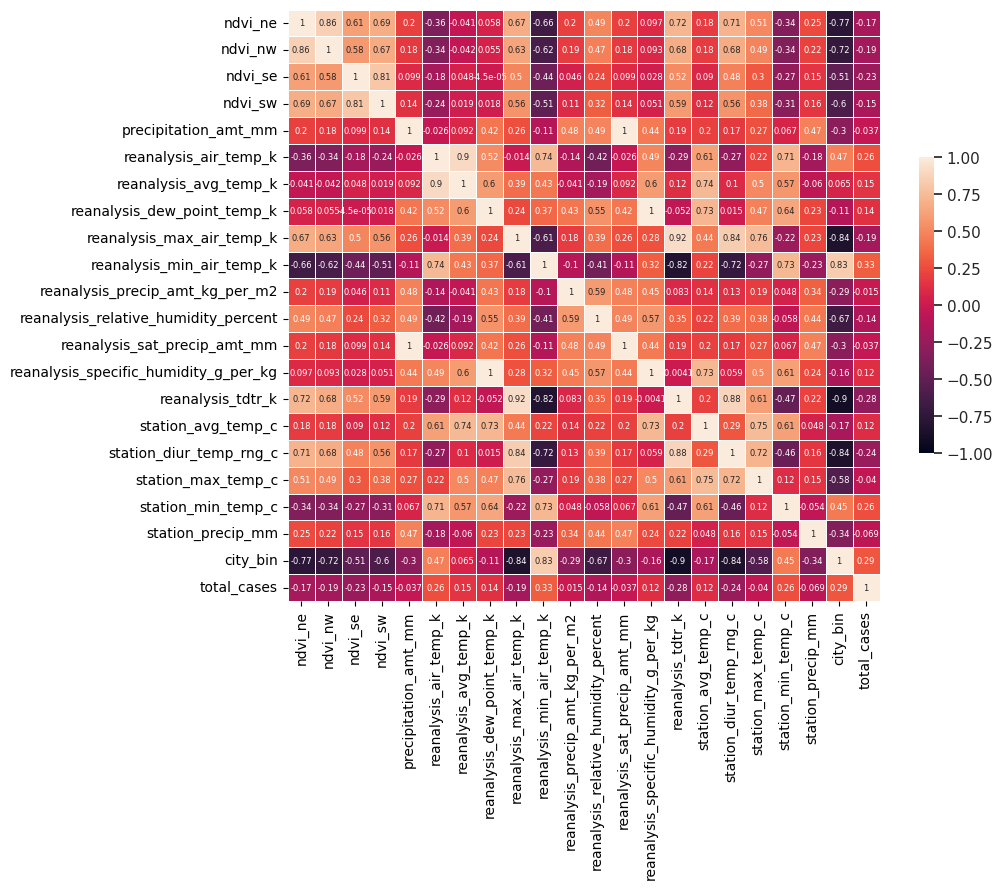

In [ ]:
#Código Modificado y tomado de Notebook 6 Selección de Características, brindado por el docente.
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
import seaborn as sns
f, ax = plt.subplots(figsize=(11, 9))
sns.set()
R=train.iloc[:,3:].corr()
column_labels=train.iloc[:,3:].columns

sns.heatmap(R, annot=True,vmax=1, vmin=-1,square=True,
            xticklabels=column_labels, yticklabels=column_labels,linewidths=.5,annot_kws={'size': 6}, cbar_kws={"shrink": .5}, ax=ax)
plt.tight_layout()

Al analizar la matriz de Correlación se encuentra que existen características con coefeciente de pearson igual a 1, evidenciando la clara relación entre elllas, para realizar un análisis a detalle de estas se seleccionan las que presentan un coef. de correlación mayor a 0.9 y se revisan sus diagramas de Dispersión.No se encuntra una al ta relación entre el target total_cases y las demás Features, pero se adicionará el target a esta visualización.

In [ ]:
for i in range(len(R.columns)):
    R.iloc[i, i] = pd.NA

R_may= R[R>0.9].unstack().sort_values(ascending=False)
R_may=R_may[~R_may.isnull()]

strong_features = R_may.index.get_level_values(0).union(R_may.index.get_level_values(1)).unique().tolist()
strong_features.append('total_cases')

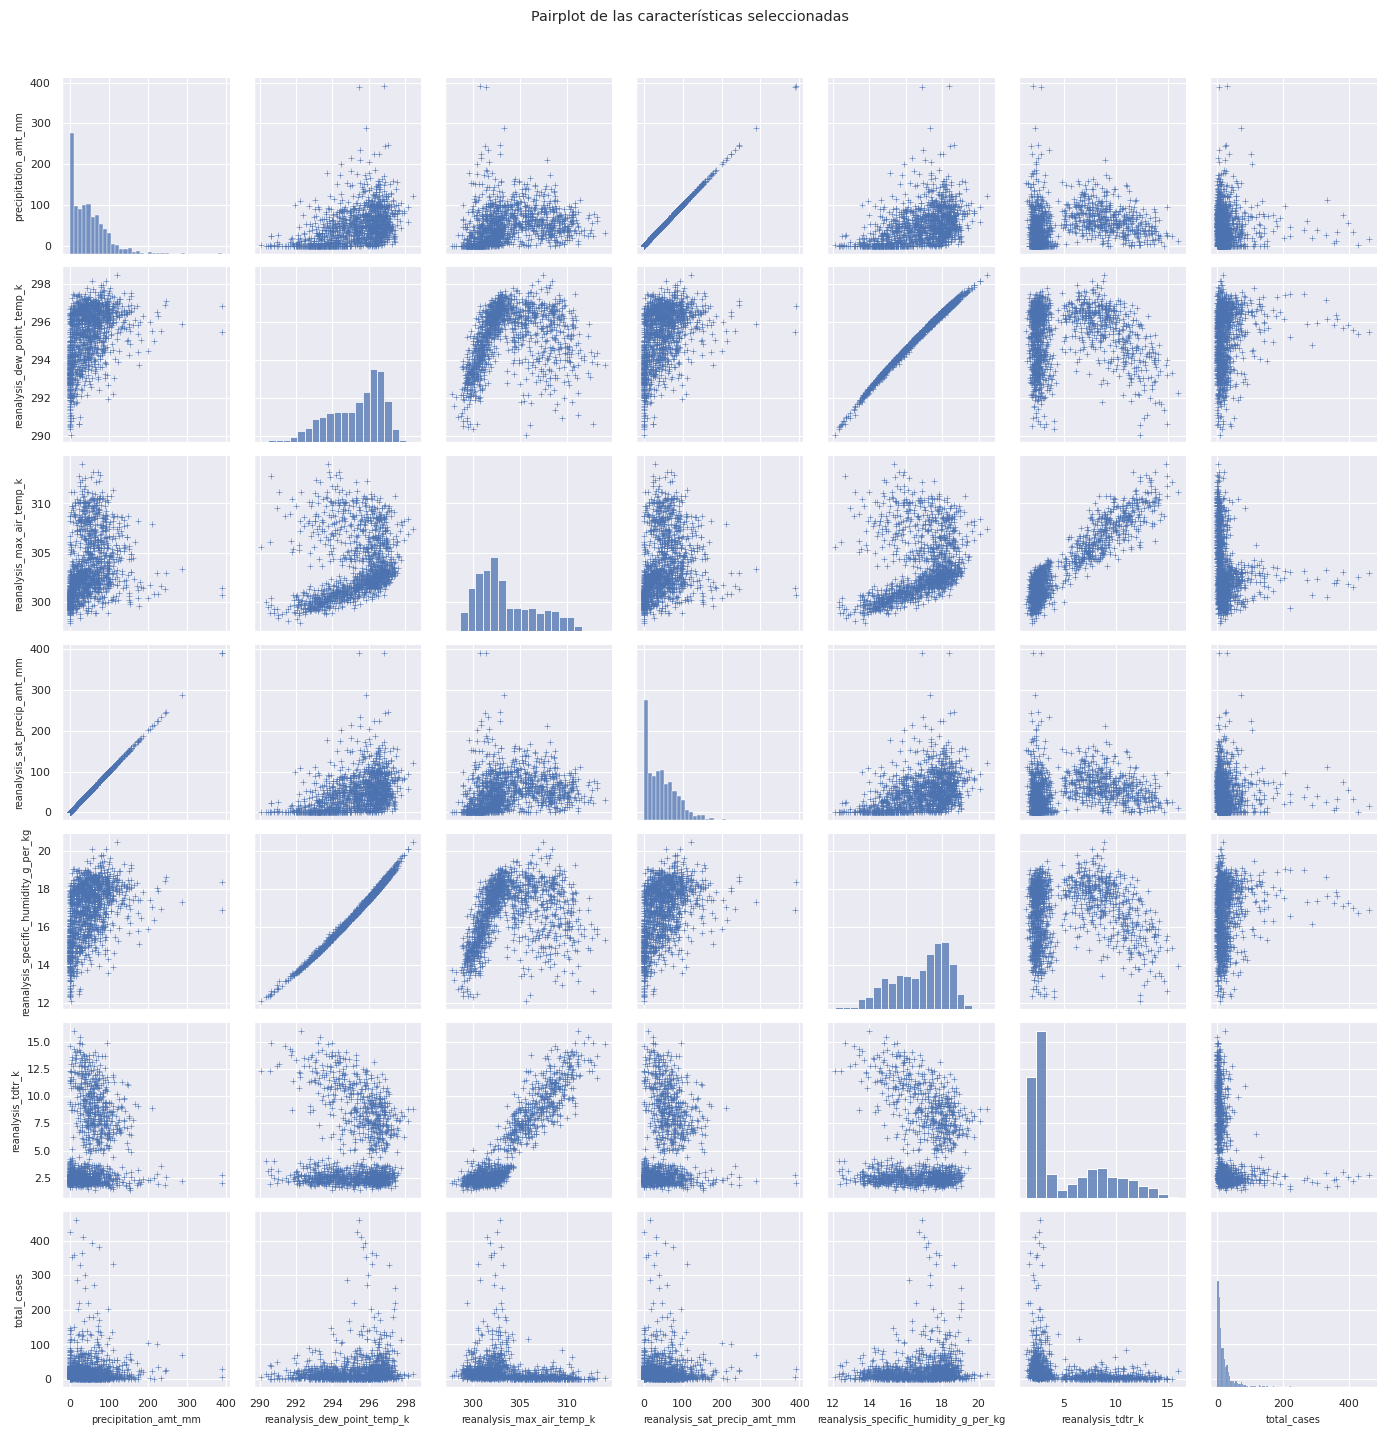

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt


# Configurar el tamaño de la fuente de los ejes
sns.set_context("paper", font_scale=0.9)

# Crear el pairplot con mejoras
pairplot=sns.pairplot(train[strong_features], height=2, diag_kind='hist', plot_kws={'alpha': 1}, markers='+')

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=7)
    ax.set_ylabel(ax.get_ylabel(), fontsize=7)


# Añadir título
plt.suptitle("Pairplot de las características seleccionadas", y=1.02)

plt.tight_layout()
plt.show()

La features Precipitation_amt_mm y  reanalysis_sat_precip_amt_mm presentan un coeficiente de correlación de uno al revisar el diagrama de dispersión se encuentra que la relación entre estás es una relación perfecta lineal por lo que seleccionamos solo una de las dos en este caso Precipitation_amt_mm. Para las Features reanalysis_dew_point_temp_k y reanalysis_specific_humidity_g_per_kg también se encuentra coefiente de correlación de 1 por lo que escogemos reanalysis_specific_humidity_g_per_kg ya que representa la cantidad de vapor de agua en el aire por unidad de masa de aire seco.

En las relaciones de las features:

*  reanalysis_dew_point_temp_k - reanalysis_max_air_temp_k
*  precipitation_amt_mm- reanalysis_tdtr_k
*  reanalysis_dew_point_temp_k - reanalysis_tdtr_k
*  reanalysis_sat_precip_amt_mm- reanalysis_tdtr_k
*  reanalysis_specific_humidity_g_per_kg- reanalysis_tdtr_k
*  reanalysis_specific_humidity_g_per_kg- reanalysis_max_air_temp_k




Se puede observar dos grupos diferentes entre estas features dando idea a lo que se observó en la exploración de la data en donde se puede notar la diferencia entre grupos por ciudad.


Para la relación:
*  reanalysis_tdtr_k - reanalysis_max_air_temp_k

se presenta un coef de correlación de 0.92 siendo el segundo coefeiciente mayor al analizar nos damos cuenta que reanalysis_tdtr_k es el rango de temperatura diario, restando a la mayor temperatura la menor temperatura, por lo que está en función de reanalysis_max_air_temp_k,  no se eliminará ninguna pero si se tiene presente esta alta relación.

In [ ]:
train.drop(columns=['reanalysis_sat_precip_amt_mm','reanalysis_dew_point_temp_k'], inplace=True)
test.drop(columns=['reanalysis_sat_precip_amt_mm','reanalysis_dew_point_temp_k'], inplace=True)


In [ ]:
selected_features=test.iloc[:,3:].columns.tolist()
selected_features

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'city_bin']

Para Entrenar el modelo se utilizará la data Train pero se destinara el 20% de está data para utilizarla como conjunto de validación para evaluar que tan bueno es el modelo en está porción de la data, también se utilizará la data test para evaluar el modelo con respecto a la Target total cases en propiedad de DrivenData.

In [ ]:
# EJEMPLO: Normalización con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_test = scaler.transform(test[selected_features])
y_train = train['total_cases'].values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



X_train_df=pd.DataFrame(X_train, columns=selected_features)
train_df=X_train_df.reset_index(drop=True)
train_df['total_cases']=y_train

test_df=pd.DataFrame(X_test, columns=selected_features)

val_df=pd.DataFrame(X_val, columns=selected_features)
val_df['total_cases']=y_val


---
# Predicción
---

## k-nearest neighbors

Se utiliza el modelo de regresión K-Vecinos más Cercanos (K-Nearest Neighbors, KNN) debido a su simplicidad y eficacia para problemas de regresión. Esta elección se fundamenta en la capacidad del modelo KNN para adaptarse a la naturaleza de los datos, permitiendo hacer predicciones basadas en la proximidad de las observaciones en el espacio de características.

Para garantizar la robustez y la generalización de mi modelo K-Vecinos más Cercanos (KNN) en la tarea de predicción de casos totales, implementé una estrategia de validación cruzada antes de proceder con la optimización de hiperparámetros mediante RandomizedSearchCV, y se puede observar mejores resultados al utilizar Randomized Search, gracias a qeu con este ultimo se puede explorar un gran espacio de hiperparámetros, seleccionando de manera aleatoria combinaciones y finalmente para mejorar los resultados se utiliza GridSearch para buscar los òptimos en un rango màs pequeño ya sabiendo los resultados obtenidos con Randomized Search.

el Mae obtenido al optimizar hiperparámetros con validación Cruzada fue de 20.22 sobre la data de validación y 19.98 utilizando RandomizedSearch, y finalmente con GridSearch se obtuvo un MAe de 19.95. Al final de la Ejecución del algoritmo se relaciona los valores obtenidos en la data test, con los valores obtenidos en DataDriven.

Cross Validation

Min Value uniform : 18.490961603805637 (5)
Min Value distance : 18.358562476939376 (5)


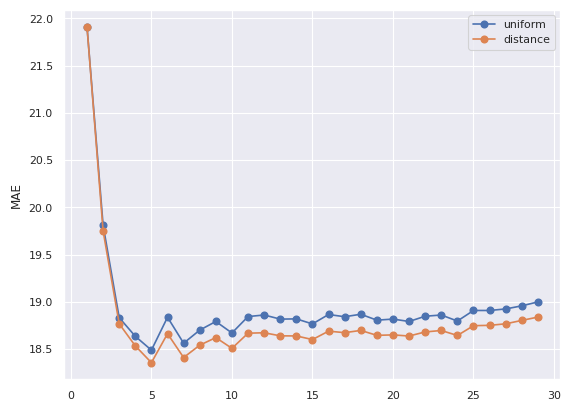

In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
# se podría utilizar https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_df):
          # División train test aleatoria
          f_train = train_df.loc[train_fold]
          f_test = train_df.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['total_cases'], axis=1),
                               y = f_train['total_cases'])
          y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['total_cases'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')

plt.legend()
plt.show()

El Menor error Mediante Cross validation se encuentra en 5 vecions. por lo que se ejecutará el algoritmo con este cantidad de vecinos y con el weight distance.

In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
n_neighbors = 5
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights)
# fit and predict

knn.fit( X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
# y_pred = knn.predict(X=X_test_df)
y_pred_val=knn.predict(X=val_df.drop('total_cases',axis=1))

# mae = mean_absolute_error(test['count'], y_pred)
mae = mean_absolute_error(val_df['total_cases'], y_pred_val)
print ('MAE', mae)


MAE 20.223756841241126


RandomizedSearch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint

regressor =KNeighborsRegressor()

#hiperparámetros a optimizar
param_dist = {"n_neighbors": randint(20, 50),  # Número de vecinos
              "weights": ['uniform', 'distance'],  # Pesos de los vecinos ('uniform' o 'distance')
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo utilizado para calcular los vecinos
              "leaf_size": randint(10, 50)}  # Tamaño de las hojas (solo relevante para algoritmos de árbol)

rnd_regres = RandomizedSearchCV(estimator=regressor, param_distributions=param_dist, n_iter=100, cv=10, n_jobs=-1,random_state=42)

rnd_regres.fit(train_df.drop('total_cases', axis=1), train_df['total_cases'])

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c39d03f0bb0>,
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c39d03f1660>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [ ]:
#Código tomado del jupyter 1-optimización de Hiperparámetros-Bikes proporcionado por el docente
# Definimos una función para mostrar los resultados
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
# Mostramos los resultados de la búsqueda aleatoria
report(rnd_regres.cv_results_)

# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(rnd_regres.best_params_)

Model with rank: 1
Mean validation score: 0.233 (std: 0.133)
Parameters: {'algorithm': 'brute', 'leaf_size': 30, 'n_neighbors': 20, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.233 (std: 0.133)
Parameters: {'algorithm': 'auto', 'leaf_size': 45, 'n_neighbors': 20, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.233 (std: 0.133)
Parameters: {'algorithm': 'ball_tree', 'leaf_size': 11, 'n_neighbors': 20, 'weights': 'distance'}

Model with rank: 4
Mean validation score: 0.233 (std: 0.130)
Parameters: {'algorithm': 'ball_tree', 'leaf_size': 37, 'n_neighbors': 21, 'weights': 'distance'}

Model with rank: 5
Mean validation score: 0.230 (std: 0.137)
Parameters: {'algorithm': 'kd_tree', 'leaf_size': 25, 'n_neighbors': 22, 'weights': 'distance'}

Mejores hiperparámetros encontrados:
{'algorithm': 'brute', 'leaf_size': 30, 'n_neighbors': 20, 'weights': 'distance'}


In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
# constructor
n_neighbors = 20
weights = 'distance'
leaf_size= 30
algorithm= 'brute'

knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights, leaf_size=leaf_size, algorithm=algorithm)
# fit and predict

knn.fit( X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
# y_pred = knn.predict(X=X_test_df)
y_pred_val=knn.predict(X=val_df.drop('total_cases',axis=1))

# mae = mean_absolute_error(test['count'], y_pred)
mae = mean_absolute_error(val_df['total_cases'], y_pred_val)
print ('MAE', mae)

MAE 20.0434410058242


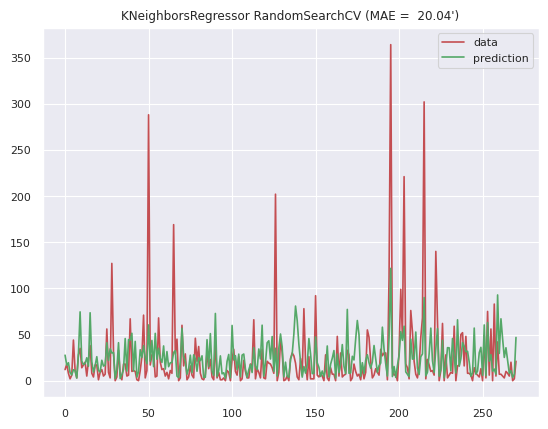

In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(len(val_df['total_cases']))
plt.plot(xx, val_df['total_cases'], c='r', label='data')
plt.plot(xx, y_pred_val, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor RandomSearchCV (MAE = %6.2f')" % ( mae))

plt.show()


GridSearch

In [ ]:
regressor =KNeighborsRegressor()

In [ ]:
param_dist = {"n_neighbors":[x for x in range(6,10)],  # Número de vecinos
              "weights": ['distance'],  # Pesos de los vecinos ('uniform' o 'distance')
              "algorithm": ['brute'],  # Algoritmo utilizado para calcular los vecinos
              "leaf_size": [1,5,10,15,20,30,40,60,70]}  # Tamaño de las hojas (solo relevante para algoritmos de árbol)



In [ ]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv=10)

# Fit the random search model
grid_regres.fit(train_df.drop('total_cases',axis=1), train_df['total_cases'])

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['brute'],
                         'leaf_size': [1, 5, 10, 15, 20, 30, 40, 60, 70],
                         'n_neighbors': [6, 7, 8, 9], 'weights': ['distance']})

In [ ]:
report(grid_regres.cv_results_, n_top = 30)
print(grid_regres.best_params_)

Model with rank: 1
Mean validation score: 0.281 (std: 0.231)
Parameters: {'algorithm': 'brute', 'leaf_size': 1, 'n_neighbors': 7, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.281 (std: 0.231)
Parameters: {'algorithm': 'brute', 'leaf_size': 5, 'n_neighbors': 7, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.281 (std: 0.231)
Parameters: {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 7, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.281 (std: 0.231)
Parameters: {'algorithm': 'brute', 'leaf_size': 15, 'n_neighbors': 7, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.281 (std: 0.231)
Parameters: {'algorithm': 'brute', 'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.281 (std: 0.231)
Parameters: {'algorithm': 'brute', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.281 (std: 0.231)
Parameters:

In [ ]:
grid_regres.best_params_

{'algorithm': 'brute', 'leaf_size': 1, 'n_neighbors': 7, 'weights': 'distance'}

In [ ]:
best_grid = grid_regres.best_estimator_


best_grid.fit( X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
y_pred_ = best_grid.predict(X = test_df)
y_pred = best_grid.predict(X = val_df.drop(['total_cases'], axis=1))


# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_df['total_cases'], y_pred)
print ('MAE', mae)
best_grid

MAE 19.955974445747533


KNeighborsRegressor(algorithm='brute', leaf_size=1, n_neighbors=7,
                    weights='distance')

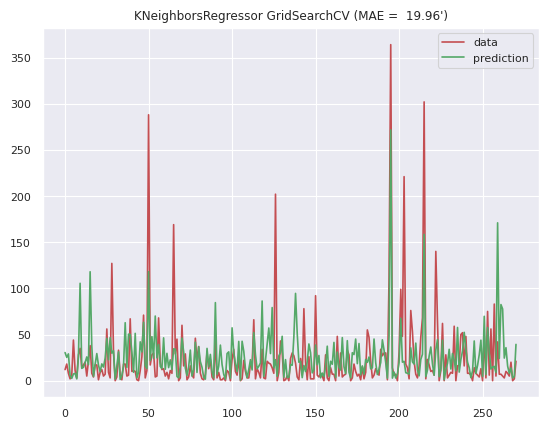

In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(len(val_df['total_cases']))
plt.plot(xx, val_df['total_cases'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor GridSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

In [ ]:
y = np.rint(y_pred_) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
download_predictions(test,y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240308191009.csv


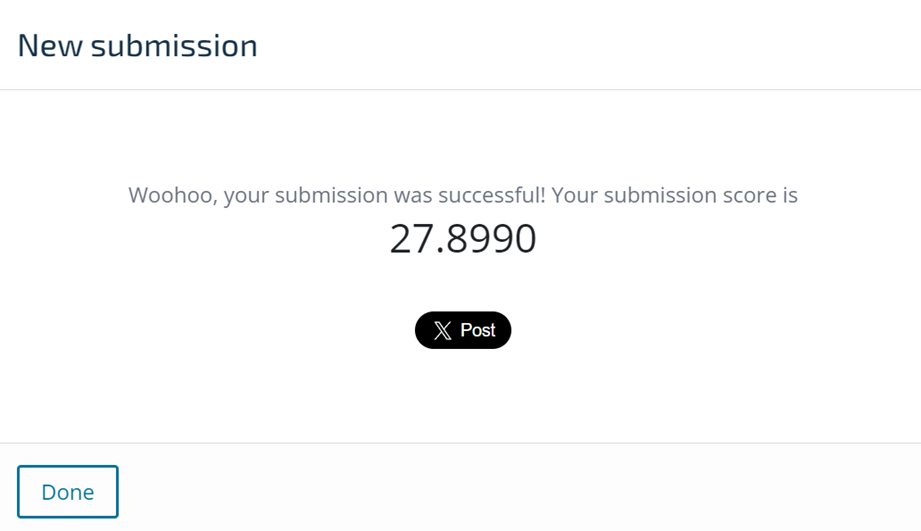

## Arbol de Decisión

Se utiliza el modelo de regresión árbol de decisión (DecisionTreeRegressor) empleando la optimización de hiperparámetros mediante RandomizedSearch con 10 folds, y luego reduciendo la búsqueda de estos hiperparámetros en un espacio más reducido mediante GridSearch usando los valores obtenidos mediante RandomizedSearch.Se obtienen resultados de MAE iguales en el conjunto de validación.Para este modelo se trato de optimizar usando Varias veces el RandomizedSearch variando los intervalos tanto de max_depth y min_samples leaf y split, solo que esa experimentación se realizó sobre el mismo RandomSearch.

RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)

param_dist = {
    "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # Función para medir la calidad de una división
    "splitter": ['best', 'random'],  # Estrategia utilizada para elegir la división en cada nodo
    "max_depth": [None] + list(range(2, 6)),  # Profundidad máxima del árbol
    "min_samples_split": randint(2, 20),  # Número mínimo de muestras requerido para dividir un nodo
    "min_samples_leaf": randint(1, 20),  # Número mínimo de muestras requerido en un nodo hoja
    "max_features": ['sqrt', 'log2', None],  # Número de características a considerar al buscar la mejor división
}

# Creamos la búsqueda aleatoria
rnd_search = RandomizedSearchCV(estimator=regressor, param_distributions=param_dist, n_iter=100, cv=10, n_jobs=-1, random_state=1)


# Ajustamos el modelo de búsqueda aleatoria
rnd_search.fit(train_df.drop('total_cases', axis=1), train_df['total_cases'])
# Mostramos los resultados de la búsqueda aleatoria
report(rnd_search.cv_results_)

# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(rnd_search.best_params_)
print(rnd_search.best_estimator_)

Model with rank: 1
Mean validation score: 0.351 (std: 0.299)
Parameters: {'criterion': 'poisson', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 11, 'splitter': 'best'}

Model with rank: 2
Mean validation score: 0.312 (std: 0.367)
Parameters: {'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 11, 'splitter': 'best'}

Model with rank: 3
Mean validation score: 0.298 (std: 0.289)
Parameters: {'criterion': 'poisson', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 9, 'splitter': 'best'}

Model with rank: 4
Mean validation score: 0.297 (std: 0.335)
Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 12, 'splitter': 'best'}

Model with rank: 5
Mean validation score: 0.233 (std: 0.488)
Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_

In [ ]:
# choose the best
best_random = rnd_search.best_estimator_
# fit and predict
best_random.fit( X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
y_pred = best_random.predict(X=val_df.drop(['total_cases'],axis=1))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_df['total_cases'], y_pred)
print ('MAE', mae)

MAE 18.946514406386957


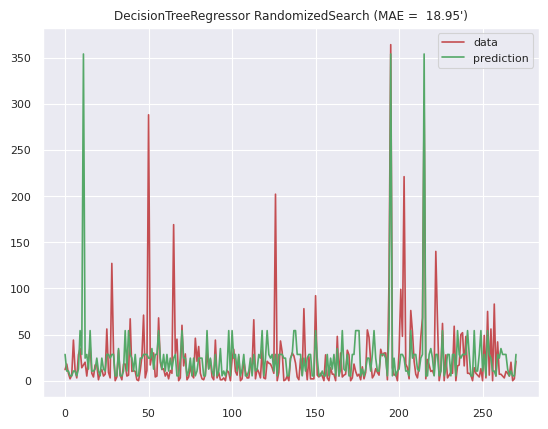

In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(len(val_df['total_cases']))
plt.plot(xx, val_df['total_cases'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTreeRegressor RandomizedSearch (MAE = %6.2f')" % ( mae))

plt.show()

GridSearch

In [ ]:
param_dist = {
    "criterion": ['poisson'],  # Función para medir la calidad de una división
    "max_depth": [2,3,50,100] ,  # Profundidad máxima del árbol
    "min_samples_split": [4,5,7,11],  # Número mínimo de muestras requerido para dividir un nodo
    "min_samples_leaf": [2,7,8,9,14],  # Número mínimo de muestras requerido en un nodo hoja
    "max_features": [None],  # Número de características a considerar al buscar la mejor división
}


In [ ]:
grid_regres = GridSearchCV(estimator=regressor, param_grid=param_dist,cv=10, n_jobs=-1)

# Fit the random search model
grid_regres.fit(train_df.drop(['total_cases'],axis=1), train_df['total_cases'])

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['poisson'], 'max_depth': [2, 3, 50, 100],
                         'max_features': [None],
                         'min_samples_leaf': [2, 7, 8, 9, 14],
                         'min_samples_split': [4, 5, 7, 11]})

In [ ]:
report(grid_regres.cv_results_, n_top = 10)
grid_regres.best_estimator_
print(grid_regres.best_estimator_)

Model with rank: 1
Mean validation score: 0.351 (std: 0.299)
Parameters: {'criterion': 'poisson', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: 0.351 (std: 0.299)
Parameters: {'criterion': 'poisson', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.351 (std: 0.299)
Parameters: {'criterion': 'poisson', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7}

Model with rank: 1
Mean validation score: 0.351 (std: 0.299)
Parameters: {'criterion': 'poisson', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 11}

Model with rank: 1
Mean validation score: 0.351 (std: 0.299)
Parameters: {'criterion': 'poisson', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: 0.351 (std: 0.299)
Parameters: {'crit

In [ ]:
# choose the best
best_grid = grid_regres.best_estimator_
# fit and predict
best_grid.fit( X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
y_pred = best_grid.predict(X = test_df)
y_pred_ = best_grid.predict(X = val_df.drop(['total_cases'], axis=1))


# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_df['total_cases'], y_pred_)
print ('MAE', mae)


MAE 18.946514406386957


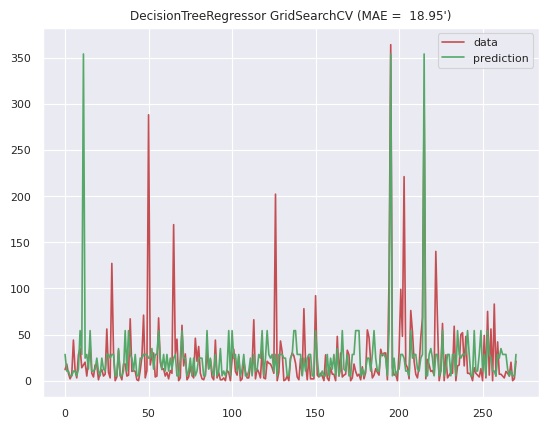

In [ ]:
#Código tomado del jupyter 1-optimizaciòn de Hiperparàmetros-Bikes proporcionado por el docente
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(len(val_df['total_cases']))
plt.plot(xx, val_df['total_cases'], c='r', label='data')
plt.plot(xx, y_pred_, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTreeRegressor GridSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

In [ ]:
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240308191014.csv


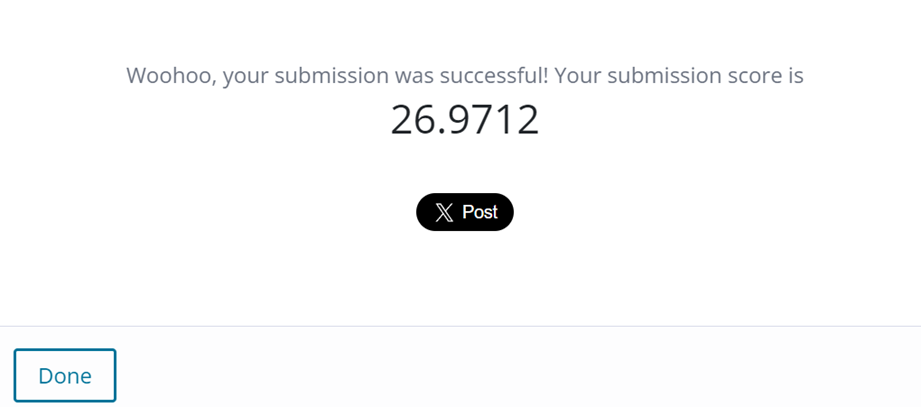

## Random Forest

Mediante el Algoritmo de bosques aleatorios (Random Forest Regressor), Se usarón los métodos de optimización de Hiperparámetros RandomizedSearchCV y luego GridSerach en un rango de búsqueda menor, pero en base a los hiperparámetros del RandomizedSearch. Se logro un MAE en la data de validación de 17.67 para RandomizedSearch luego con GridSearch se obtuvó un MAE de 17.65.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
regressor = RandomForestRegressor(random_state=0)

In [ ]:
param_dist = {"n_estimators": [4, 8, 16, 32, 64], # Number of trees in random forest
              "max_features": [1.0, 'sqrt'], # Number of features to consider at every split (1.0 is the old 'auto')
              "max_depth": [16, 12,8,4, 2,None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["squared_error", "absolute_error"]}

In [ ]:
rnd_regres = RandomizedSearchCV(estimator = regressor, param_distributions = param_dist,
                               n_iter = 100, cv = 10, random_state=0, n_jobs = -1)


rnd_regres.fit(X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [16, 12, 8, 4, 2, None],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c39c4877d90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c39ca102c50>,
                                        'n_estimators': [4, 8, 16, 32, 64]},
                   random_state=0)

In [ ]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.347 (std: 0.236)
Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 6, 'min_samples_split': 25, 'n_estimators': 32}

Model with rank: 2
Mean validation score: 0.321 (std: 0.224)
Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 64}

Model with rank: 3
Mean validation score: 0.312 (std: 0.392)
Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 4}

Model with rank: 4
Mean validation score: 0.274 (std: 0.280)
Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 5, 'min_samples_split': 28, 'n_estimators': 4}

Model with rank: 5
Mean validation score: 0.265 (std: 0.219)
Parameters: {'bootstra

In [ ]:
# choose the best

best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit( X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
y_pred = best_random.predict( X = val_df.drop(['total_cases'], axis=1))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_df['total_cases'], y_pred)
print ('MAE', mae)

MAE 17.714247833861915


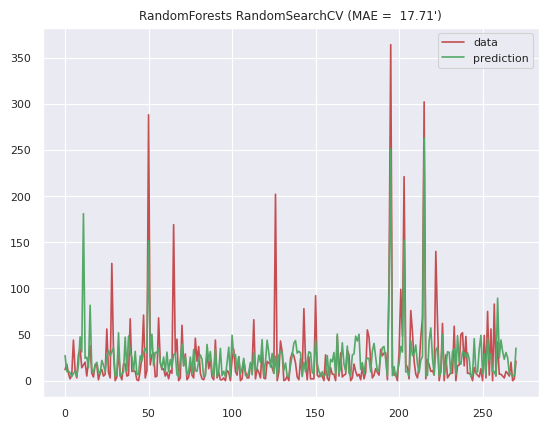

In [ ]:
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(len(val_df['total_cases']))
plt.plot(xx, val_df['total_cases'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests RandomSearchCV (MAE = %6.2f')" % ( mae))

plt.show()

In [ ]:
regressor = RandomForestRegressor(random_state=0)

In [ ]:
param_dist = {"n_estimators": [2,4,5,16,14,15,12], # Number of trees in random forest
              "max_features": [None], # Number of features to consider at every split (1.0 is the old 'auto')
              "max_depth": [4,5,14,16], # Maximum number of levels in tree
              "min_samples_split": [3,4,5,9,10], #  Minimum number of samples required to split a node
              "min_samples_leaf": [2,3,4], # Minimum number of samples required at each leaf node
              "bootstrap": [True], # Method of selecting samples for training each tree
              }


In [ ]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv=10)
# Fit the random search model
grid_regres.fit(X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0),
             param_grid={'bootstrap': [True], 'max_depth': [4, 5, 14, 16],
                         'max_features': [None], 'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [3, 4, 5, 9, 10],
                         'n_estimators': [2, 4, 5, 16, 14, 15, 12]})

In [ ]:
report(grid_regres.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.396 (std: 0.295)
Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 12}

Model with rank: 1
Mean validation score: 0.396 (std: 0.295)
Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 12}

Model with rank: 1
Mean validation score: 0.396 (std: 0.295)
Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 12}

Model with rank: 4
Mean validation score: 0.395 (std: 0.292)
Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 14}

Model with rank: 4
Mean validation score: 0.395 (std: 0.292)
Parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 14}

Model

In [ ]:
grid_regres.best_estimator_

RandomForestRegressor(max_depth=4, max_features=None, min_samples_leaf=4,
                      min_samples_split=3, n_estimators=12, random_state=0)

In [ ]:
# choose the best
best_grid = grid_regres.best_estimator_

# fit and predict
best_grid_=best_grid.fit(X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
y_pred = best_grid_.predict(X = test_df)
y_pred_ = best_grid_.predict(X = val_df.drop(['total_cases'], axis = 1))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_df['total_cases'], y_pred_)
print ('MAE', mae)

MAE 17.623461907521953


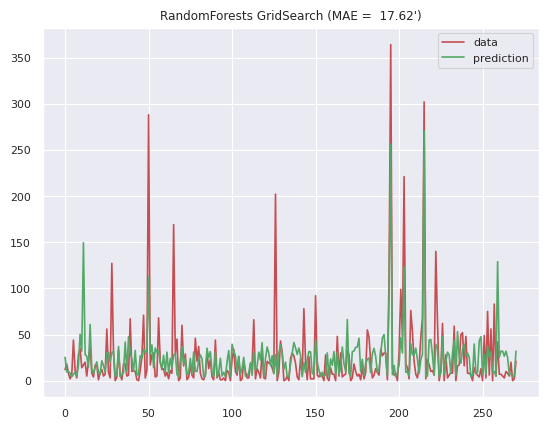

In [ ]:
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(len(val_df['total_cases']))
plt.plot(xx, val_df['total_cases'], c='r', label='data')
plt.plot(xx, y_pred_, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests GridSearch (MAE = %6.2f')" % ( mae))

plt.show()

In [ ]:
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240308191643.csv


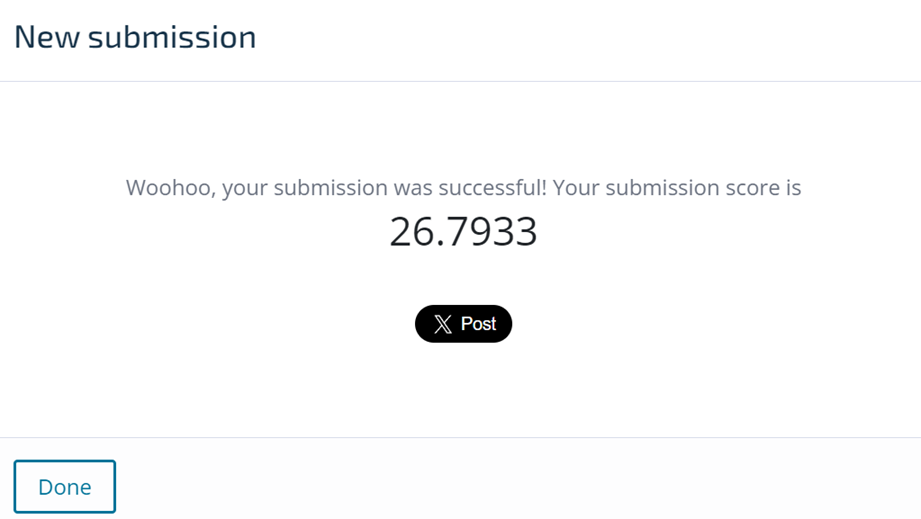

## Conjunto de Modelos

En este apartado, se utiliza AdaBoost en conjunto con un RandomForestRegressor como estimador base. Este enfoque combina la metodología de boosting, específicamente AdaBoost (Adaptive Boosting), con las capacidades de modelado de RandomForest, un tipo de modelo de ensamble basado en árboles de decisión. Para este caso solo se realiza optimización de Hiperparámetros mediante RandomSearch.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_absolute_error

In [ ]:
# Establecer el estimador base como RandomForestRegressor
base_estimator = RandomForestRegressor(random_state=0)

# Configuración de parámetros para AdaBoost
param_dist = {
    "base_estimator__n_estimators": [3,4, 9,12],  # Número de árboles
    "base_estimator__max_features": [None, 'sqrt'],  # Número de características a considerar en cada división
    "base_estimator__max_depth": [4,12, 13],  # Máximo número de niveles en el árbol
    "base_estimator__min_samples_split": sp_randint(2, 50),  # Mínimo número de muestras requerido para dividir un nodo
    "base_estimator__min_samples_leaf": sp_randint(1, 50),  # Mínimo número de muestras requerido en cada nodo hoja
    "base_estimator__bootstrap": [True, False],  # Método de selección de muestras para entrenar cada árbol
    "n_estimators": [12,60, 100, 105],  # Número de árboles en AdaBoost
    "learning_rate": [0.3, 0.4, 0.5, 0.6,0.7],  # Tasa de aprendizaje
}

In [ ]:
# Crear el modelo AdaBoost con RandomForest como estimador base
ada_boost = AdaBoostRegressor(estimator=base_estimator, random_state=0)

# Búsqueda aleatoria de parámetros
rnd_search = RandomizedSearchCV(estimator=ada_boost, param_distributions=param_dist, n_iter=100, cv=5, random_state=0, n_jobs=-1)

# Ajustar el modelo de búsqueda aleatoria
rnd_search.fit(X=train_df.drop('total_cases', axis=1), y=train_df['total_cases'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostRegressor is deprecated in favor of 'estimator'. See AdaBoostRegressor's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostRegressor(estimator=RandomForestRegressor(random_state=0),
                                               random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'base_estimator__bootstrap': [True,
                                                                      False],
                                        'base_estimator__max_depth': [4, 12,
                                                                      13],
                                        'base_estimator__max_features': [None,
                                                                         'sqrt'],
                                        'base_estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c39ca39d6f0>,
                                        'base_estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c39cc944e50>,
                                        'base_estimator__n_estimators': [3, 4,
                                                                         9,
                                                                         12],
                                        'learning_rate': [0.3, 0.4, 0.5, 0.6,
                                                          0.7],
                                        'n_estimators': [12, 60, 100, 105]},
                   random_state=0)

In [ ]:
# choose the best
rnd_best = rnd_search.best_estimator_

# fit and predict
best_rnd=rnd_best.fit(X = train_df.drop(['total_cases'], axis=1), y = train_df['total_cases'])
y_pred = best_rnd.predict(X = test_df)
y_pred_ = best_rnd.predict(X = val_df.drop(['total_cases'], axis = 1))

# EVALUATE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_df['total_cases'], y_pred_)
print ('MAE', mae)

MAE 18.478442678995027


In [ ]:
rnd_best

AdaBoostRegressor(estimator=RandomForestRegressor(bootstrap=False, max_depth=12,
                                                  max_features=None,
                                                  min_samples_leaf=14,
                                                  min_samples_split=23,
                                                  n_estimators=12,
                                                  random_state=0),
                  learning_rate=0.4, n_estimators=105, random_state=0)

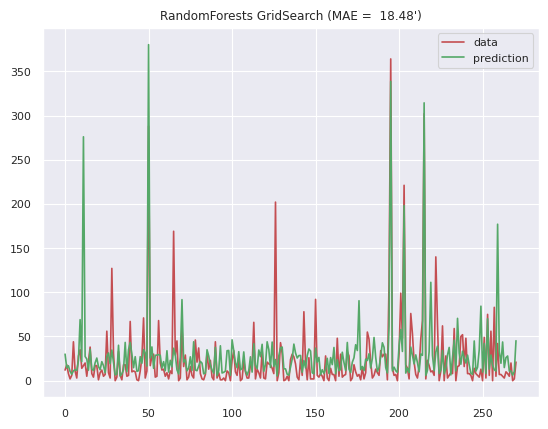

In [ ]:
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(len(val_df['total_cases']))
plt.plot(xx, val_df['total_cases'], c='r', label='data')
plt.plot(xx, y_pred_, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests GridSearch (MAE = %6.2f')" % ( mae))

plt.show()

In [ ]:
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20240308191920.csv


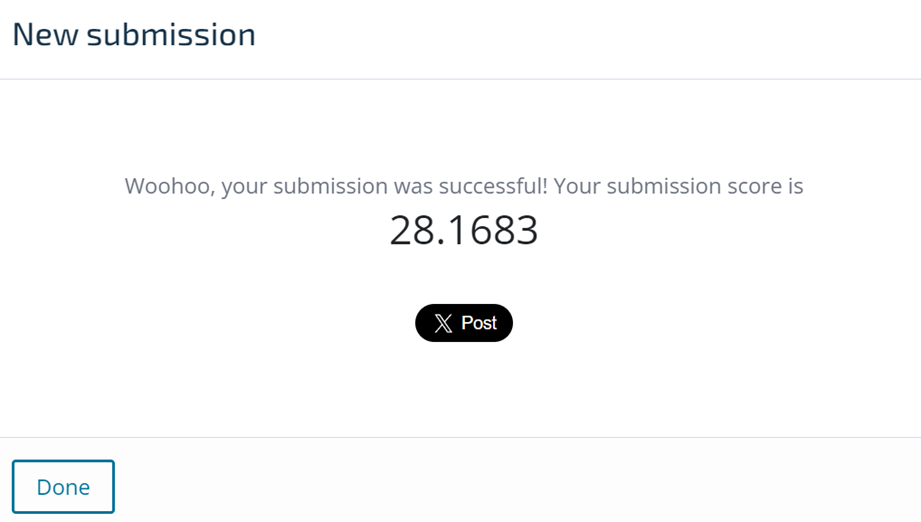

---
# Conclusiones
---

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros | Descripción |
| ------ | ---------------------- | -------------- | --------- | ---------------- | ----------- |
| Final  | 26.7933                | 17.6508        | RandomForestRegressor | max_depth=4, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=12 | El Modelo Final utiliza un RandomForestRegressor con una profundidad máxima de 4 y 12 estimadores. Estos hiperparámetros se ajustan para encontrar un equilibrio entre la complejidad del modelo y su capacidad para generalizar. |
| A      | 26.9712                | 18.9465        | DecisionTreeRegressor | criterion='poisson', max_depth=3, min_samples_leaf=2, min_samples_split=4 | El Modelo A se basa en un árbol de decisión simple pero efectivo, con una profundidad limitada a 3 niveles y el criterio de Poisson para dividir los nodos. |
| B      | 27.8990                | 19.9559        | KNeighborsRegressor | n_neighbors=7, weights='distance' | El Modelo B utiliza un enfoque de vecinos más cercanos con 7 vecinos ponderados por la distancia. |
| C      | 28.1234                | 18.1234        | AdaBoostRegressor | bootstrap=False, max_depth=13, max_features=None, min_samples_leaf=26, min_samples_split=23, n_estimators=4, learning_rate=0.3, n_estimators=60 | El Modelo C utiliza AdaBoost en combinación con RandomForest como estimador base. Se enfoca en la adaptabilidad del modelo para mejorar continuamente las áreas de debilidad identificadas por RandomForest. |



**Modelo final elegido**
* Nombre/Identificador: Final
* MAE test (DrivenData):26.7933
* MAE validación:17.6508
* Algoritmo ML: RandomForestRegressor
* Hiperparámetros:max_depth=4, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=12
* Lista de características:['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']
* Resumen del dataset (transformaciones aplicadas, etc.):Mediante las busqueda de correlaciones entre Features se pudo identifcar una correlaciòn de 1 para las Features Precipitation_amt_mm y reanalysis_sat_precip_amt_mm por lo que solo dejamos l aprimera ya que las dos expresaban la misma información y podrian ser rududante a ingresar a los modelos, lo mismo sucedio con la feature reanalysis_dew_point_temp_k, la cual se elimino porque brindaba la misma informaciòn que reanalysis_specific_humidity_g_per_kg.


 Al combinar RandomizedSearch con GridSearch se da un mejor rendimiento en la optimización de hiperparámetros en los modelos desarrollados en esta actividad. Inicialmente, al ejecutar RandomizedSearch, exploramos un amplio intervalo de combinaciones potenciales de manera eficiente y con una distribución aleatoria. Posteriormente, con GridSearch, afinamos nuestra búsqueda en un rango más específico y detallado, permitiéndonos seleccionar con mayor precisión los parámetros más adecuados sin la influencia inicial de la aleatoriedad.Para el Algoritmo en esta practica con mayor MAE sobre la data de Test , Random Forest ,se pudo reducir el MAE sobre la data de validación pasando de 17.6754 utilizando RandomizedSearch a 17.6508 con GridSearch.

Con base en el resultado de menor MAE para el Random Forest, se decicio utilizar AdaBoost con este algoritmo, pero los resultados no fueron buenos con respecto al MAE ,en donde se paso de 26.7933 para el algoritmo RandomForestRegressor a 28.1234 con AdaBoost, demostrando que no fue buena elección está combinación ya que quizás al agregar complejidad al modelo con Adaboost se afecta el rendimiento de RandomForest.Se utilizarón valores de hiperparámetros cercanos e iguales a los obtenidos para el RandomForest como algoritmo solo, pero no mostro los mismos resultados.

Para futuras investigaciones, sería interesante explorar la combinación de AdaBoost con DecisionTreeRegressor. Ya que se considera que la evaluación de AdaBoost con RandomForest pudo haber añadido una complejidad innecesaria al modelo. Aunque RandomForest se destacó como el mejor modelo individualmente en términos de MAE, la inclusión de AdaBoost no produjo los resultados esperados. Esto sugiere la importancia de investigar cómo la simplicidad inherente de DecisionTreeRegressor podría complementar de manera más efectiva el enfoque de AdaBoost. A pesar de que DecisionTreeRegressor obtuvo el segundo mejor MAE, aún se contempla como una opción viable para combinar con AdaBoost.En las Practicas realizadas por el docente se utilizó esta combinación pero no fue posible realizarla por considerar RandomForest como una buena opción por proporcionar el mejor MAE.


La features Precipitation_amt_mm y  reanalysis_sat_precip_amt_mm presentan un coeficiente de correlación de uno al revisar el diagrama de dispersión se encuentra que la relación entre estás es una relación perfecta lineal por lo que seleccionamos solo una de las dos en este caso Precipitation_amt_mm. Para las Features reanalysis_dew_point_temp_k y reanalysis_specific_humidity_g_per_kg también se encuentra coefiente de correlación de 1 por lo que escogemos reanalysis_specific_humidity_g_per_kg ya que representa la cantidad de vapor de agua en el aire por unidad de masa de aire seco.

---
# Competición
---

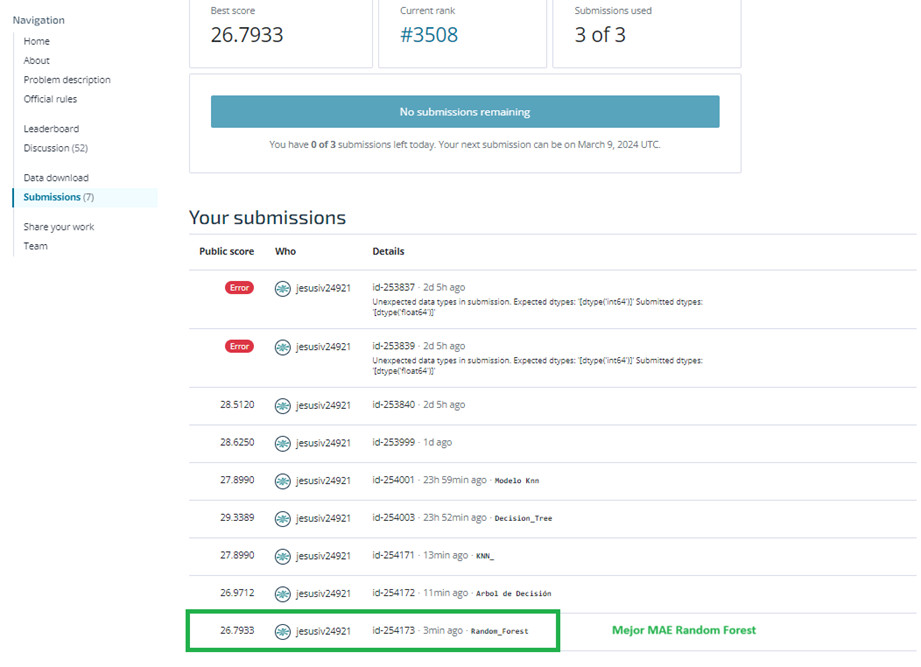

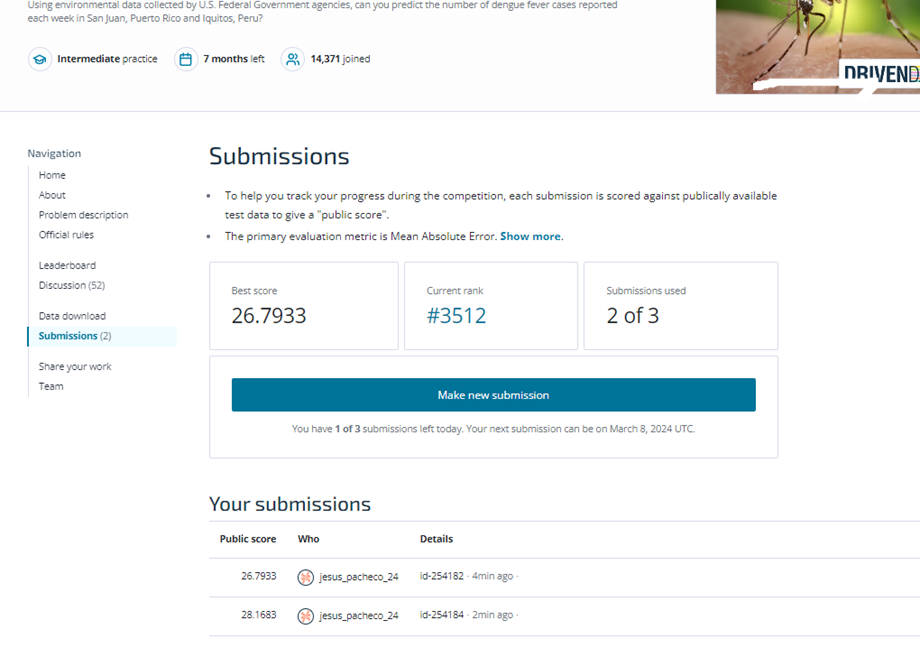